### Equipo: 

- Nombre de alumno 1: Nicolas Herrera
- Nombre de alumno 2: Lucas Carrasco

### **Link de repositorio de GitHub:** [Repositorio](https://github.com/vspartamo/MDS7202)

### Indice
1. [Introducción](#Introducción:)
2. [Análisis Exploratorio de Datos](#Análisisexploratoriodedatos:)
3. [Modelamiento](#3-modelamiento)
4. [Monitoreo](#monitoreo)

# Introducción

En el presente Jupyter Notebook se presenta el desarrollo del proyecto final del curso Laboratorio de programación científica, donde se implementa tranversalmente los conocimientos adquiridos en el curso en un problema de clasificación binaria. Se busca predecir si un cliente presentará morosidad o no, para esto se utilizará datos con grandes cantidades de columnas, los que se estudian en el Análisis Exploratorio de Datos. A grandes rasgos, los datos incluyen para cada cliente su registro bancario, al

A lo largo de todo el proyecto se busca maximizar el ROC-AUC dado que esta permite cuantizar la capacidad de los modelos para diferenciar claramente  entre dos clases, que se alinea con el objetivo del proyecto por sobre métricas como Accuracy o Precision, ya que estas penalizan más los falsos negativos o falsos positivos acordemente, no contemplando así la totalidad de lo esperado para lo que llamaríamos un buen modelo. Pese a esto, también es cierto que en el contexto de este problema, los falsos positivos pueden ser penalizados con menos rigor que los falsos negativos (considerando la clase positiva como un cliente moroso), ya que no representa pérdidas directas para el banco. Se implementa modelos de clasificación basados en árboles y boosting, en particular Decision Tree, Random Forest, XGBoost y LGBoost, siendo el de mejores resultados XGBoost. Este modelo alcanzó un buen desempeño en los conjuntos de entrenamiento y tuvo un buen despliegue, no mostrando overfitting, lo que permitió que obtuviera buenos resultados ante los otros equipos, en especial en la segunda entrega del proyecto, donde logró ubicarse en la segunda posición en el ranking de la competencia. 

## **2 Preprocesamiento**
### **2.1 Análisis exploratorio de datos**


Se realiza un análisis exploratorio de datos para identificar patrones, tendencias y relaciones en ellos. Esto para comprender mejor las características del conjunto de datos y guiar las siguientes decisiones en el pipeline de modelamiento.

In [58]:
#%pip install pyarrow pandas scikit-learn matplotlib seaborn

In [59]:
# Se importan las librerías básicas para trabajar los datos y visualizarlos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
DATA_PATH = "data/"
X_t0 = pd.read_parquet(DATA_PATH + "X_t0.parquet")
y_t0 = pd.read_parquet(DATA_PATH + "y_t0.parquet")

df_t0 = pd.concat([X_t0, y_t0], axis=1)
df_t0.head()

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,...,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0


In [61]:
df_t0.columns

Index(['borrow_block_number', 'borrow_timestamp', 'wallet_address',
       'first_tx_timestamp', 'last_tx_timestamp', 'wallet_age',
       'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
       'total_gas_paid_eth', 'avg_gas_paid_per_tx_eth', 'risky_tx_count',
       'risky_unique_contract_count', 'risky_first_tx_timestamp',
       'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
       'risky_sum_outgoing_amount_eth', 'outgoing_tx_sum_eth',
       'incoming_tx_sum_eth', 'outgoing_tx_avg_eth', 'incoming_tx_avg_eth',
       'max_eth_ever', 'min_eth_ever', 'total_balance_eth', 'risk_factor',
       'total_collateral_eth', 'total_collateral_avg_eth',
       'total_available_borrows_eth', 'total_available_borrows_avg_eth',
       'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
       'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
       'borrow_amount_avg_eth', 'borrow_count', 'repay_amount_sum_eth',
       'repay_am

Se entrega una breve descripción de cada una de las 78 columnas:
#### **Datos generales del wallet**
- **`borrow_block_number`**: Número del bloque en el que ocurrió el préstamo más reciente asociado al monedero.
- **`borrow_timestamp`**: Marca de tiempo (timestamp) del préstamo más reciente.
- **`wallet_address`**: Dirección del monedero que identifica al usuario.
- **`first_tx_timestamp`**: Timestamp de la primera transacción registrada para este monedero.
- **`last_tx_timestamp`**: Timestamp de la última transacción registrada.
- **`wallet_age`**: Tiempo total desde la primera transacción hasta la fecha actual, generalmente en días o meses.

#### **Estadísticas de transacciones**
- **`incoming_tx_count`**: Número total de transacciones entrantes al monedero.
- **`outgoing_tx_count`**: Número total de transacciones salientes desde el monedero.
- **`net_incoming_tx_count`**: Diferencia entre las transacciones entrantes y salientes.
- **`total_gas_paid_eth`**: Cantidad total de gas pagado en ETH por todas las transacciones.
- **`avg_gas_paid_per_tx_eth`**: Promedio de gas pagado por transacción, expresado en ETH.

#### **Datos sobre transacciones riesgosas**
- **`risky_tx_count`**: Número de transacciones clasificadas como riesgosas.
- **`risky_unique_contract_count`**: Número de contratos únicos involucrados en transacciones riesgosas.
- **`risky_first_tx_timestamp`**: Timestamp de la primera transacción riesgosa.
- **`risky_last_tx_timestamp`**: Timestamp de la última transacción riesgosa.
- **`risky_first_last_tx_timestamp_diff`**: Diferencia temporal entre la primera y la última transacción riesgosa.
- **`risky_sum_outgoing_amount_eth`**: Suma de ETH enviados en transacciones riesgosas.

#### **Estadísticas de ETH en el monedero**
- **`outgoing_tx_sum_eth`**: Suma total de ETH enviados en todas las transacciones salientes.
- **`incoming_tx_sum_eth`**: Suma total de ETH recibidos en todas las transacciones entrantes.
- **`outgoing_tx_avg_eth`**: Promedio de ETH enviados por transacción saliente.
- **`incoming_tx_avg_eth`**: Promedio de ETH recibidos por transacción entrante.
- **`max_eth_ever`**: Máximo balance de ETH alcanzado en el monedero.
- **`min_eth_ever`**: Mínimo balance de ETH registrado en el monedero.
- **`total_balance_eth`**: Balance actual del monedero en ETH.
- **`risk_factor`**: Indicador del nivel de riesgo asociado al monedero, basado en algún modelo de análisis.

#### **Estadísticas de préstamos y colaterales**
- **`total_collateral_eth`**: Suma total de ETH utilizados como colateral.
- **`total_collateral_avg_eth`**: Promedio de ETH usados como colateral por préstamo.
- **`total_available_borrows_eth`**: Monto total de ETH disponible para préstamo.
- **`total_available_borrows_avg_eth`**: Promedio de ETH disponibles para préstamo.
- **`avg_weighted_risk_factor`**: Factor de riesgo ponderado promedio.
- **`risk_factor_above_threshold_daily_count`**: Número de días en los que el factor de riesgo estuvo por encima de un umbral predefinido.
- **`avg_risk_factor`**: Promedio del factor de riesgo del monedero.
- **`max_risk_factor`**: Máximo valor del factor de riesgo registrado.
- **`borrow_amount_sum_eth`**: Suma total de ETH prestados.
- **`borrow_amount_avg_eth`**: Promedio de ETH prestados por transacción.
- **`borrow_count`**: Número total de transacciones de préstamo.
- **`repay_amount_sum_eth`**: Suma total de ETH devueltos.
- **`repay_amount_avg_eth`**: Promedio de ETH devueltos por transacción.
- **`repay_count`**: Número total de transacciones de devolución.
- **`borrow_repay_diff_eth`**: Diferencia entre ETH prestados y devueltos.

#### **Estadísticas de depósitos y retiros**
- **`deposit_count`**: Número de transacciones de depósito realizadas.
- **`deposit_amount_sum_eth`**: Suma total de ETH depositados.
- **`time_since_first_deposit`**: Tiempo transcurrido desde el primer depósito.
- **`withdraw_amount_sum_eth`**: Suma total de ETH retirados.
- **`withdraw_deposit_diff_if_positive_eth`**: Diferencia positiva entre ETH retirados y depositados.
- **`liquidation_count`**: Número de veces que el monedero fue liquidado.
- **`time_since_last_liquidated`**: Tiempo transcurrido desde la última liquidación.
- **`liquidation_amount_sum_eth`**: Suma total de ETH liquidados.

#### **Indicadores del mercado**
- **`market_adx`, `market_adxr`, `market_apo`, etc.**: Indicadores técnicos basados en análisis del mercado, como fuerza direccional (ADX), Momentum, osciladores (Aroon), volatilidad (ATR), fuerza relativa (CCI), entre otros. Estos se usan comúnmente para evaluar tendencias o comportamientos del mercado.

#### **Estadísticas adicionales**
- **`unique_borrow_protocol_count`**: Número de protocolos de préstamos únicos utilizados.
- **`unique_lending_protocol_count`**: Número de protocolos de préstamos ofrecidos.
- **`target`**: Variable objetivo, posiblemente para un modelo de predicción (como riesgo de impago o clasificación).

### **Limpieza de los datos**

Se remueve las columnas que corresponden a identificadores o no aportan información relevante al problema.

In [62]:
columns_to_drop = [
    'borrow_block_number',
    'wallet_address',
    'borrow_timestamp',
    'first_tx_timestamp',
    'last_tx_timestamp',
    'risky_first_tx_timestamp',
    'risky_last_tx_timestamp',
    'unique_borrow_protocol_count',
    'unique_lending_protocol_count',
]

df_t0_columns_dropped = df_t0.drop(columns=columns_to_drop, inplace=False)

df_t0_columns_dropped.shape

(44296, 69)

In [63]:
#vemos la existencia de nulos
sum(df_t0_columns_dropped.isna().sum() > 0)

0

In [64]:
df_t0_columns_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 69 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   wallet_age                               44296 non-null  float64
 1   incoming_tx_count                        44296 non-null  int64  
 2   outgoing_tx_count                        44296 non-null  int64  
 3   net_incoming_tx_count                    44296 non-null  int64  
 4   total_gas_paid_eth                       44296 non-null  float64
 5   avg_gas_paid_per_tx_eth                  44296 non-null  float64
 6   risky_tx_count                           44296 non-null  int64  
 7   risky_unique_contract_count              44296 non-null  int64  
 8   risky_first_last_tx_timestamp_diff       44296 non-null  int64  
 9   risky_sum_outgoing_amount_eth            44296 non-null  float64
 10  outgoing_tx_sum_eth                      44296

In [65]:
#identificamos las columnas numericas, no hay categoricas
numeric_features = df_t0_columns_dropped.select_dtypes(include=['int64', 'float64']).columns
train_numeric_features = numeric_features.drop('target')
# identificar las columnas categoricas
categoric_features = df_t0_columns_dropped.select_dtypes(include = ['object']).columns
categoric_features 

Index([], dtype='object')

In [66]:
#estadísticas generales de las columnas numéricas
print(df_t0_columns_dropped.describe())

         wallet_age  incoming_tx_count  outgoing_tx_count  \
count  4.429600e+04       44296.000000       44296.000000   
mean   2.943773e+07         999.369514        1360.256231   
std    2.897753e+07        3065.153260        3936.526950   
min    1.370000e+02           1.000000           0.000000   
25%    3.641601e+06          34.000000          52.000000   
50%    1.900256e+07         134.000000         207.000000   
75%    5.196818e+07         471.000000         678.000000   
max    1.540836e+08       98747.000000       71087.000000   

       net_incoming_tx_count  total_gas_paid_eth  avg_gas_paid_per_tx_eth  \
count           44296.000000        44296.000000             44296.000000   
mean             -360.886717            2.717345                 0.002874   
std              2167.545039           13.380028                 0.008137   
min            -68013.000000            0.000000                 0.000000   
25%              -198.000000            0.076647                 

In [67]:
# ver el desbalance de clases en la columna target 
df_t0_columns_dropped['target'].value_counts(normalize=True)

target
1    0.511468
0    0.488532
Name: proportion, dtype: float64

In [68]:
import matplotlib.pyplot as plt
import math

def plot_numeric_histograms(df, numeric_features, n_cols=6, title="Análisis Univariado de las Variables Numéricas"):
    """
    Función para graficar histogramas de variables numéricas en un DataFrame usando Matplotlib.

    Parameters:
    - df (pd.DataFrame): El DataFrame que contiene las variables a graficar.
    - numeric_features (list): Lista de nombres de las columnas numéricas a graficar.
    - n_cols (int): Número de columnas en la cuadrícula de subplots.
    - title (str): Título del gráfico.
    """
    # Calcular el número de filas necesarias
    n_rows = math.ceil(len(numeric_features) / n_cols)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()  # Asegurar que sea un array plano para indexar

    # Iterar sobre cada variable numérica y graficar
    for idx, col in enumerate(numeric_features):
        ax = axes[idx]
        ax.hist(df[col], bins=30, density=True, color="skyblue", edgecolor="black")
        ax.set_title(col, fontsize=12)
        ax.set_xlabel("Valores", fontsize=10)
        ax.set_ylabel("Frecuencia", fontsize=10)

    # Eliminar ejes sobrantes si hay menos gráficos que espacios
    for idx in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[idx])

    # Ajustar el layout y agregar título general
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [69]:
chunk_size = len(numeric_features) // 3
numeric_features_1 = numeric_features[:chunk_size]
numeric_features_2 = numeric_features[chunk_size:2*chunk_size]
numeric_features_3 = numeric_features[2*chunk_size:]

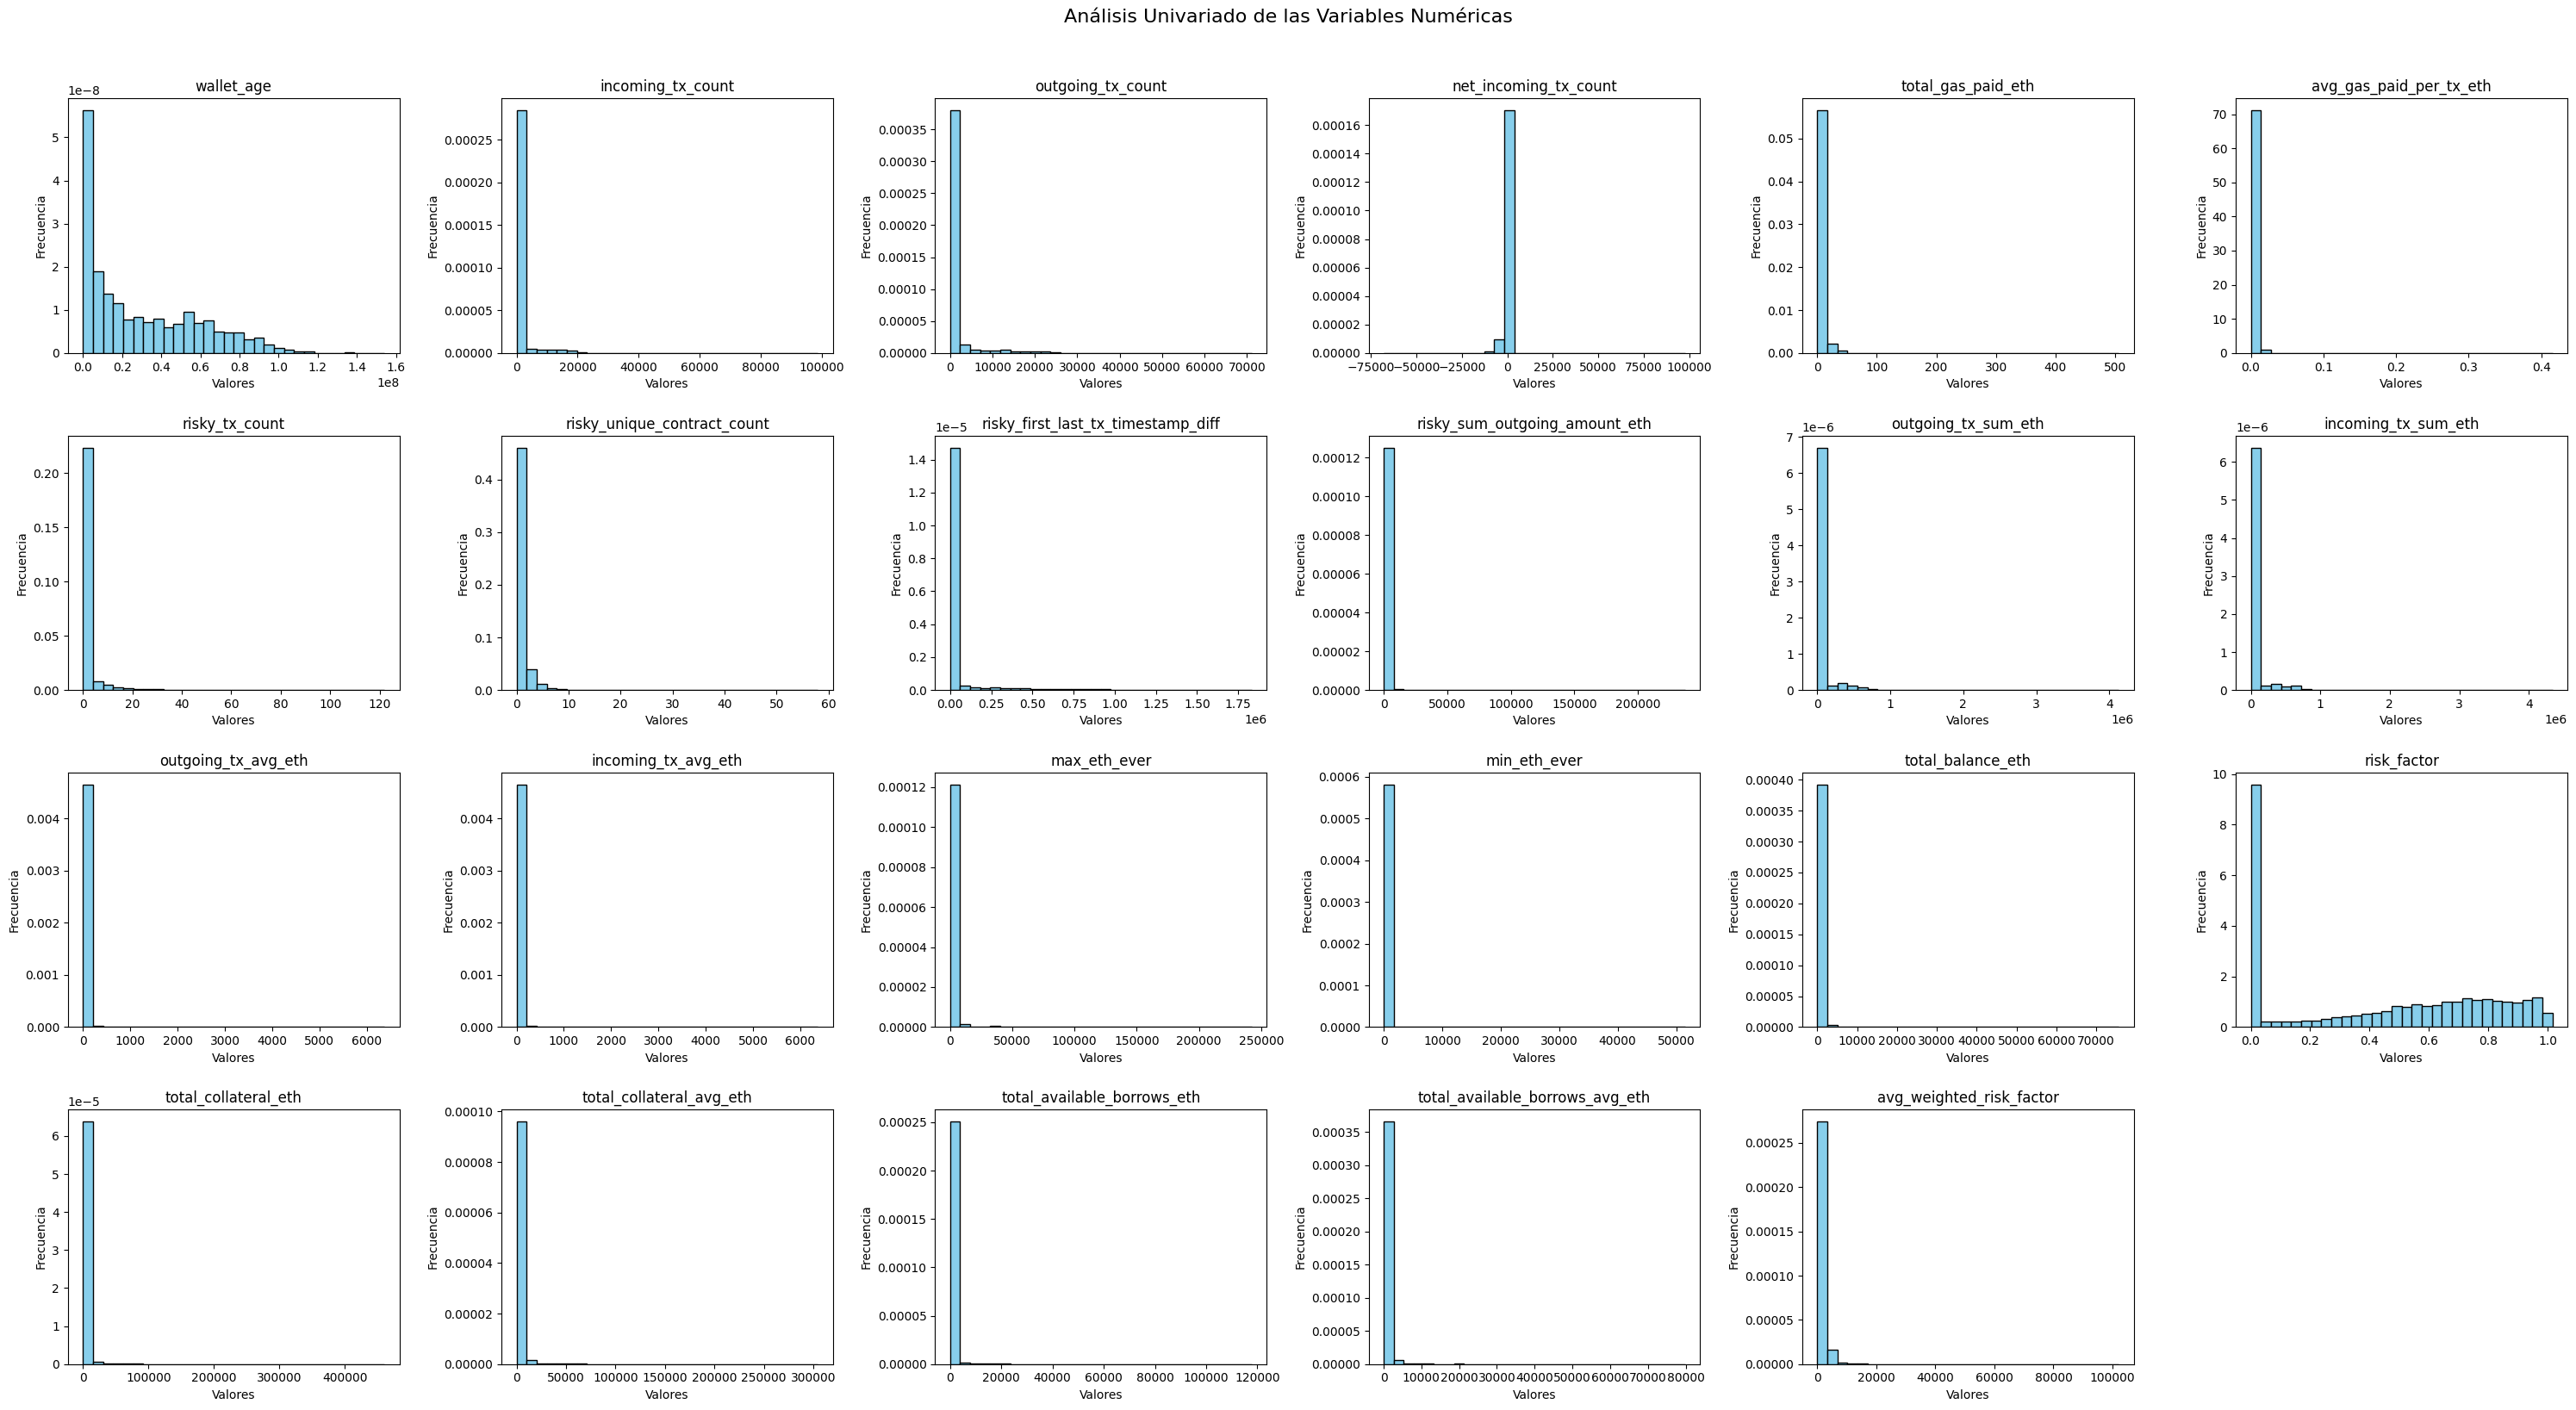

In [70]:
plot_numeric_histograms(df_t0_columns_dropped, numeric_features_1)

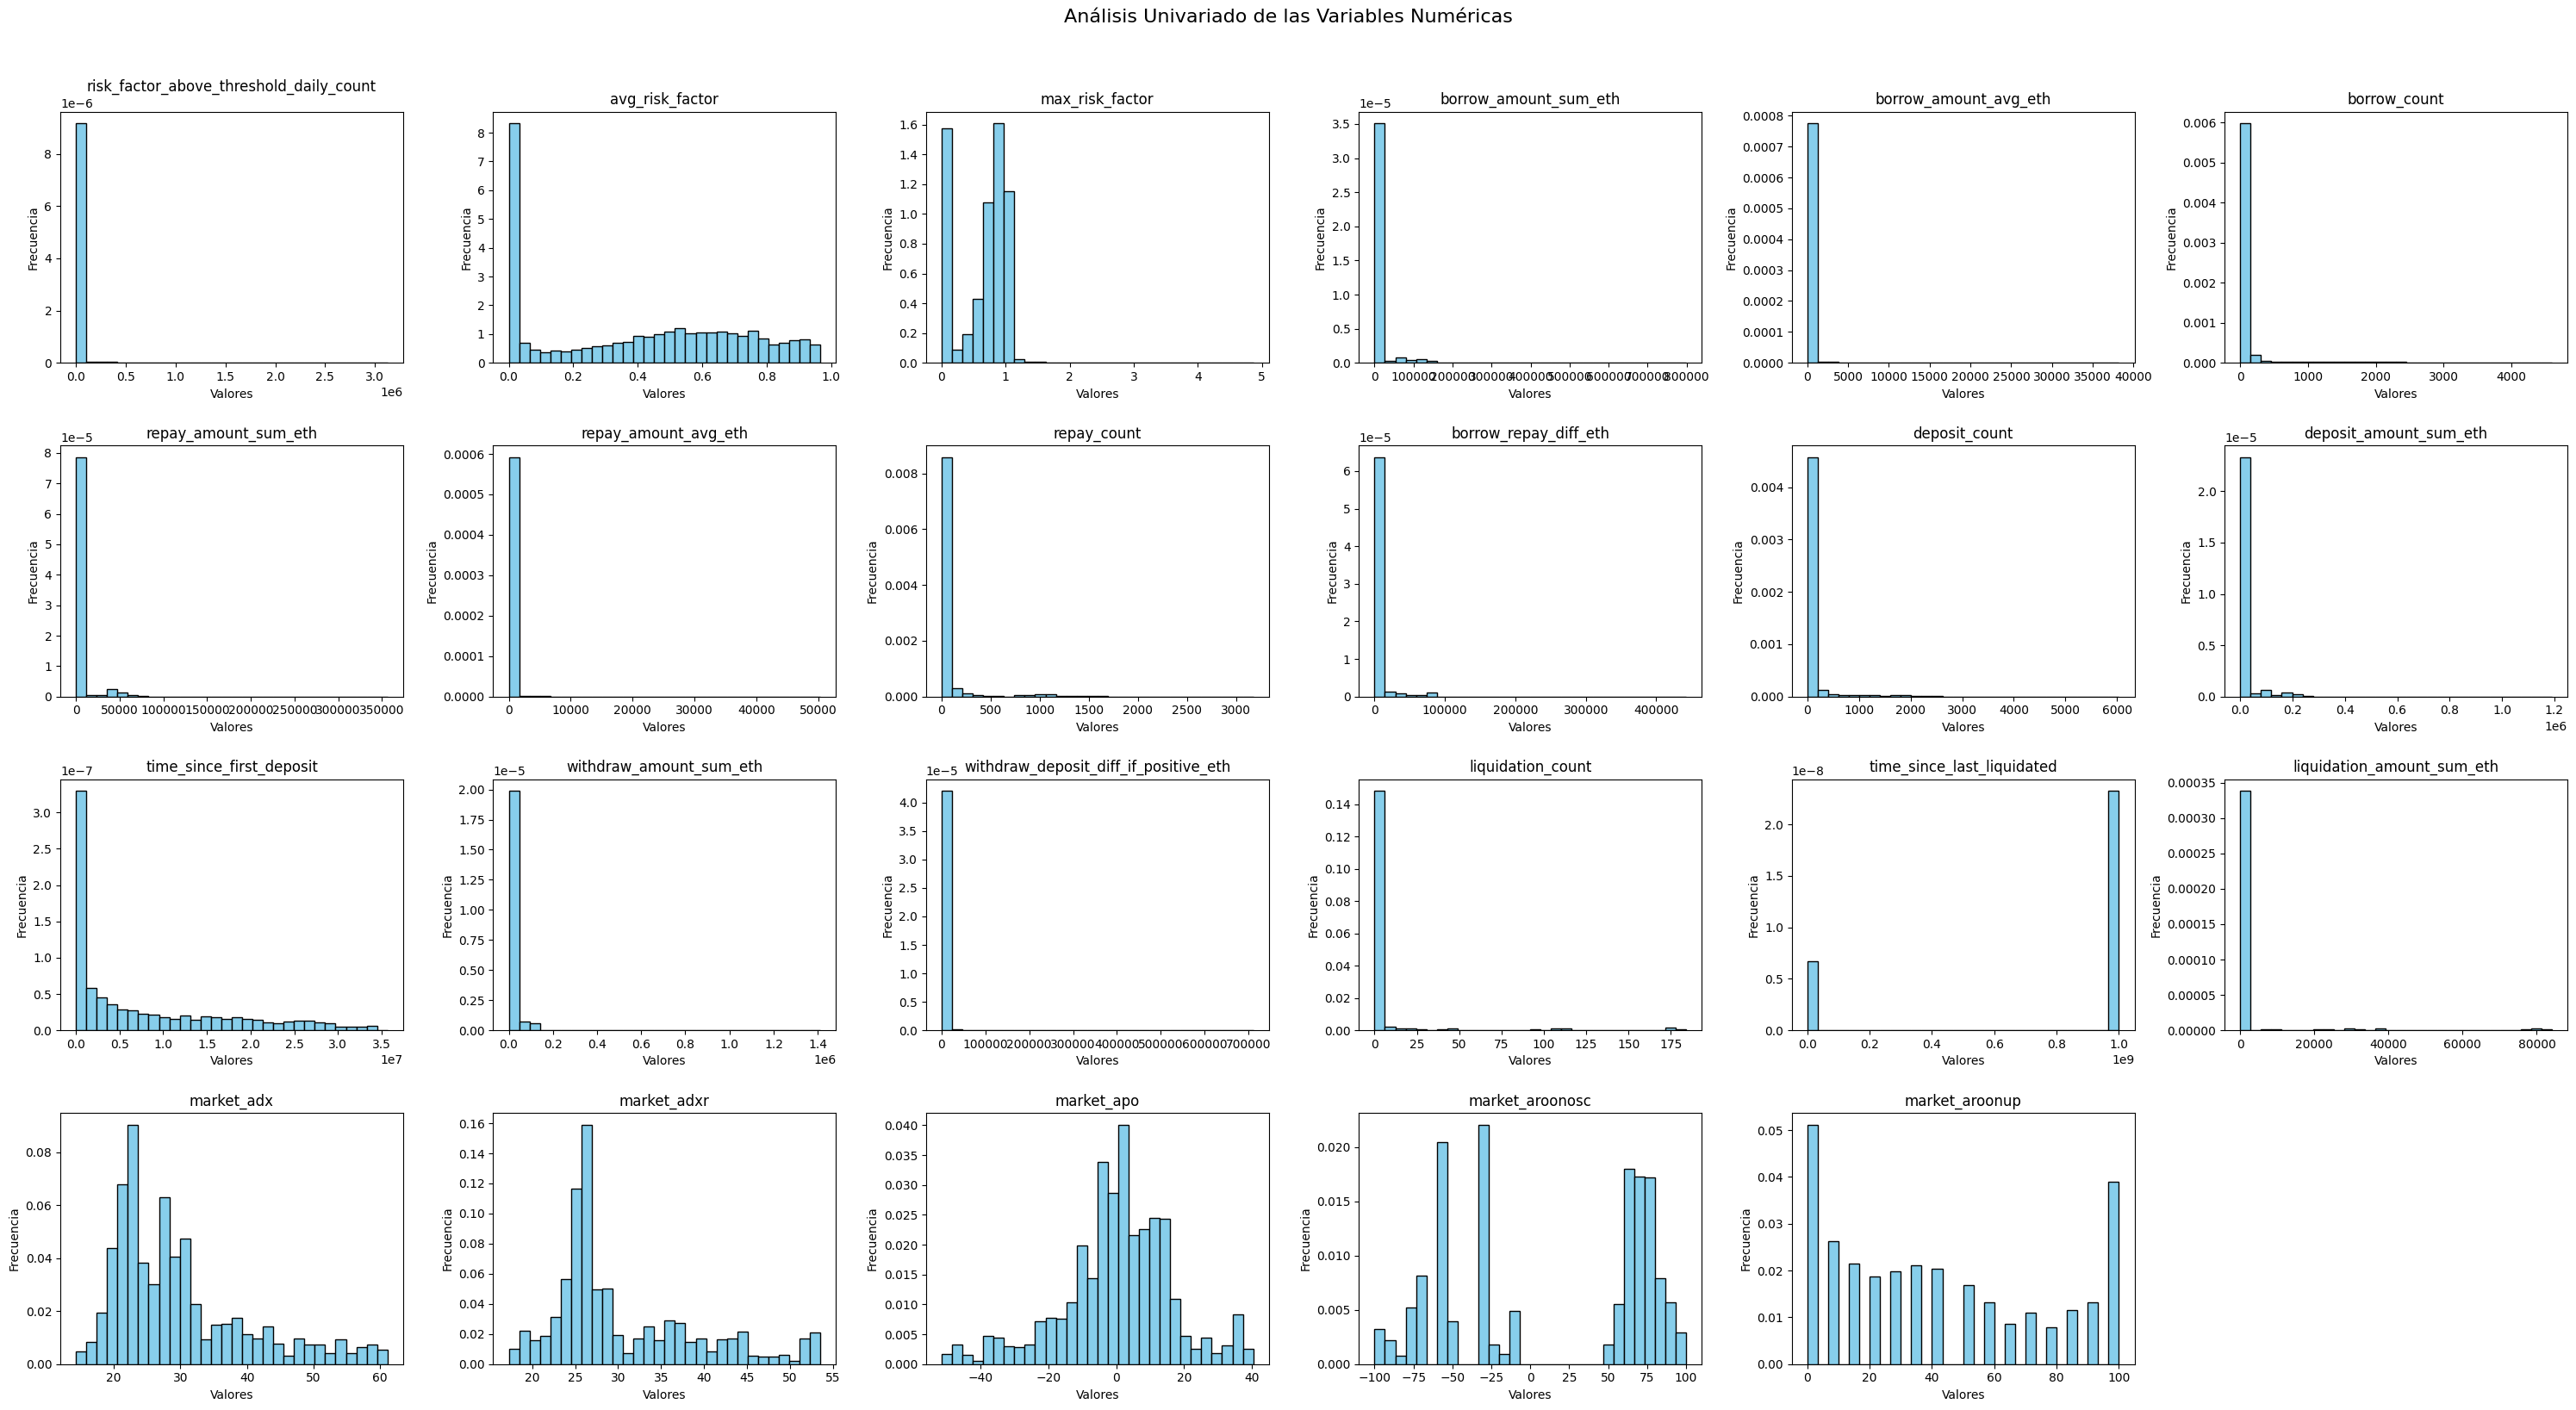

In [71]:
plot_numeric_histograms(df_t0_columns_dropped, numeric_features_2)

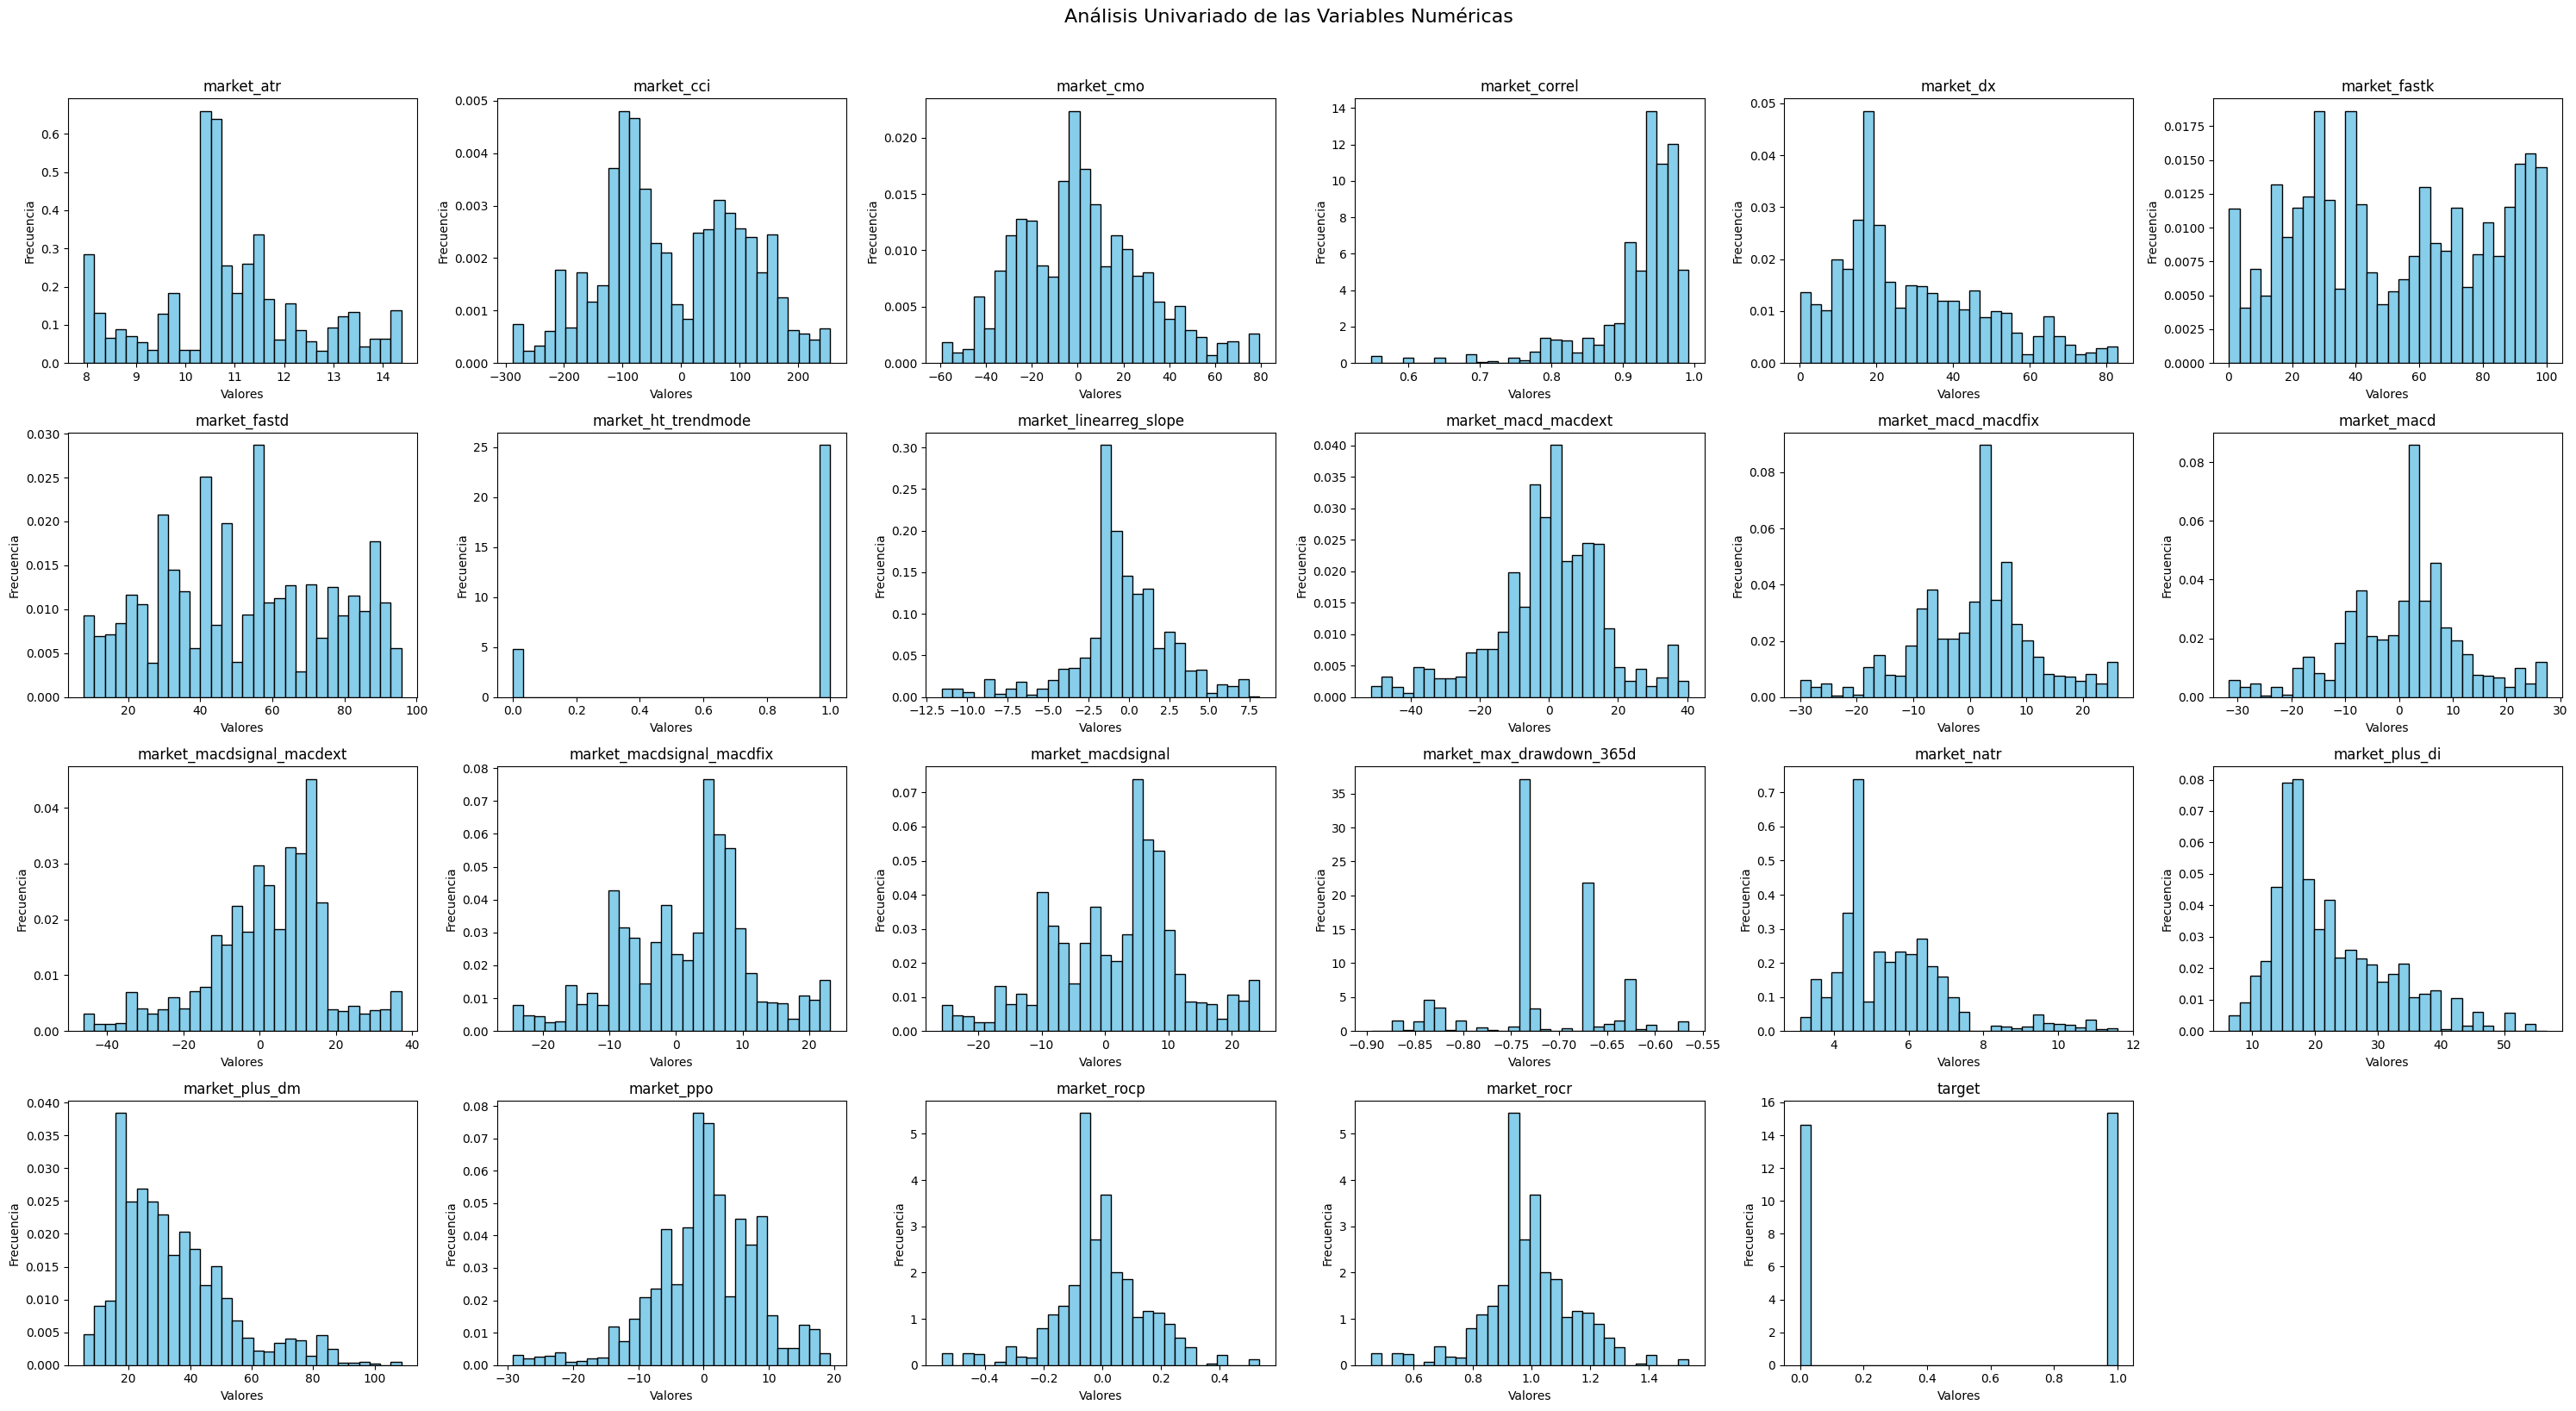

In [72]:
plot_numeric_histograms(df_t0_columns_dropped, numeric_features_3)

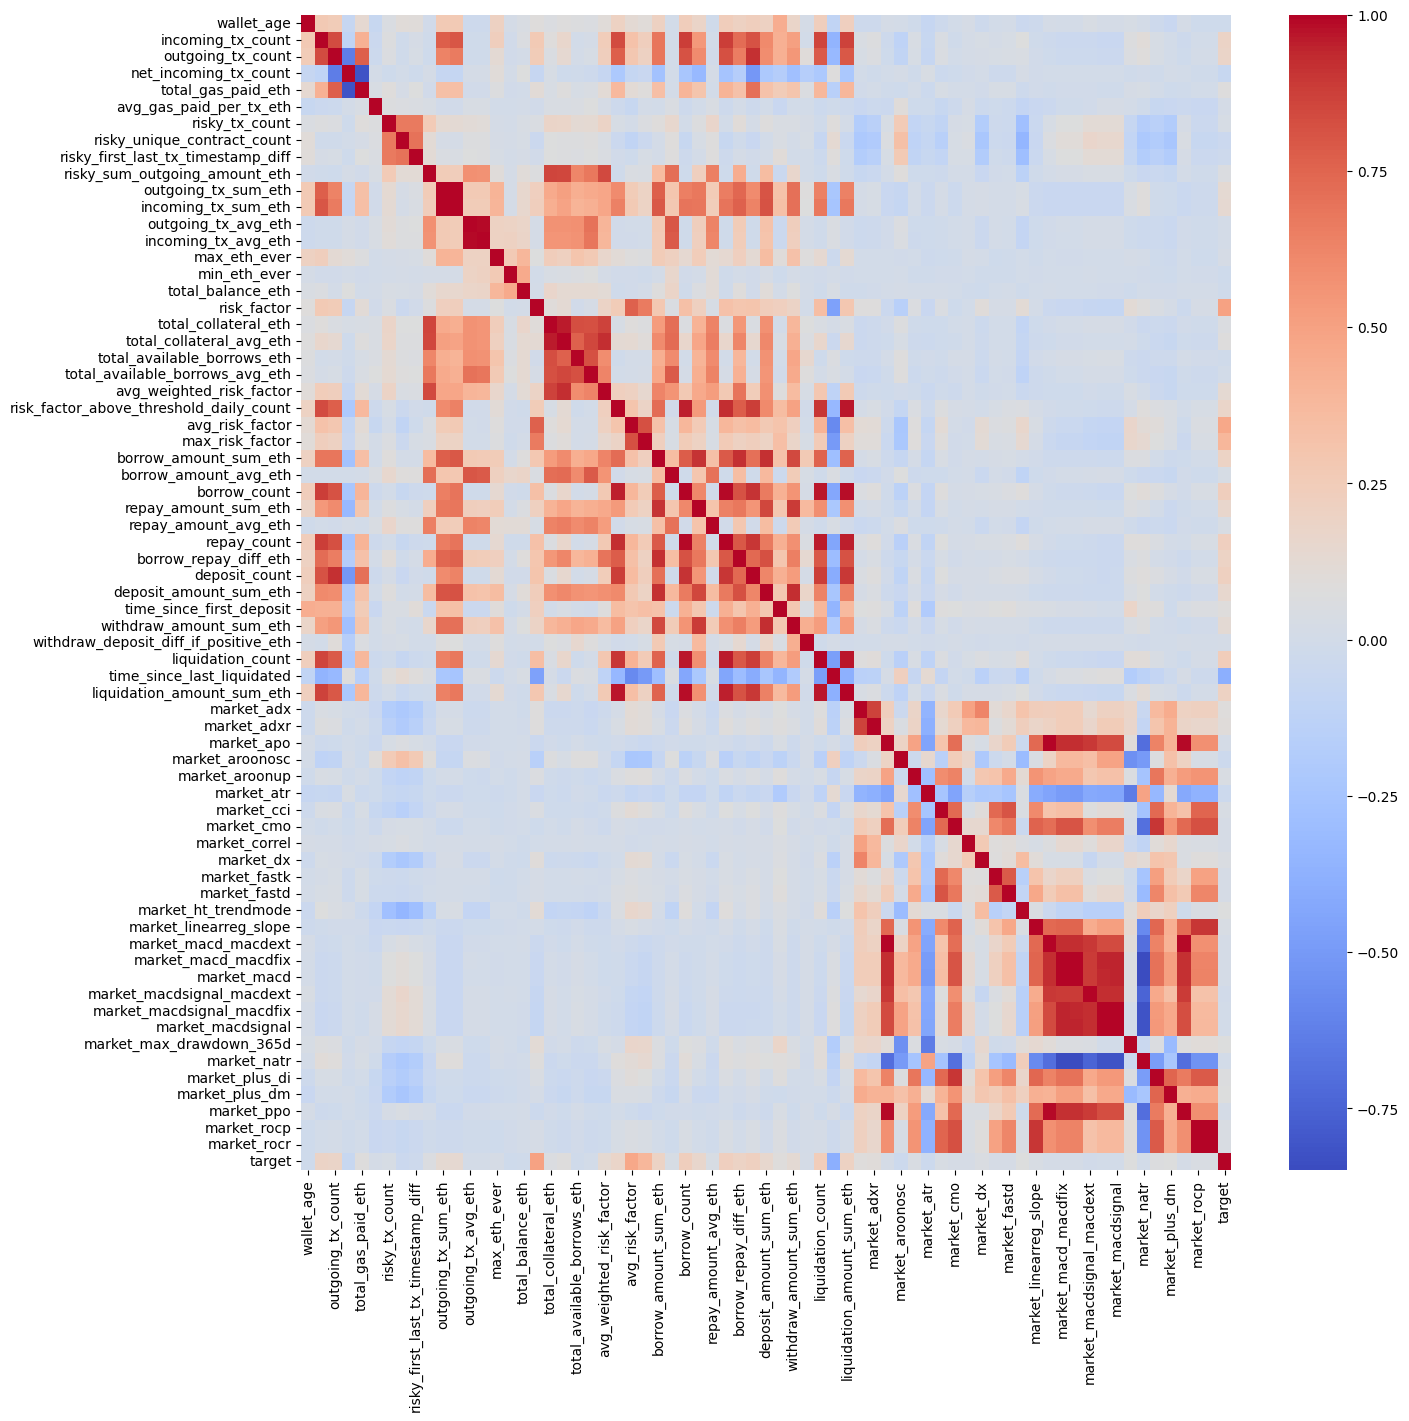

In [73]:
# Se estudia la correlación de features
correlation_matrix = df_t0_columns_dropped[numeric_features].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [74]:
def get_top_correlated_groups(df, n=10, m=2):
    """
    Función para obtener los n grupos de m columnas más relacionadas entre sí.

    Parameters:
    - df (pd.DataFrame): DataFrame que contiene las columnas a analizar.
    - n (int): Número de grupos a retornar.
    - m (int): Número de columnas en cada grupo.

    Returns:
    - list: Lista de tuplas, donde cada tupla contiene las columnas de un grupo y su correlación promedio.
    """
    corr_matrix = df.corr().abs()  
    np.fill_diagonal(corr_matrix.values, 0) 

    groups = []
    used_columns = set()

    for _ in range(n):
        # Encontrar el par de columnas más correlacionadas no utilizadas
        max_corr = corr_matrix.max().max()
        idx = corr_matrix.stack().idxmax()
        top_features = list(idx)

        # Agregar las columnas adicionales más correlacionadas si m > 2
        if m > 2:
            remaining_corrs = corr_matrix.loc[top_features].mean(axis=0).sort_values(ascending=False)
            for col in remaining_corrs.index:
                if col not in used_columns and col not in top_features:
                    top_features.append(col)
                if len(top_features) == m:
                    break

        # Calcular la correlación promedio del grupo
        avg_corr = corr_matrix.loc[top_features, top_features].mean().mean()
        groups.append((tuple(top_features), avg_corr))

        
        used_columns.update(top_features)
        corr_matrix.loc[top_features, :] = 0
        corr_matrix.loc[:, top_features] = 0

    return groups


In [75]:
get_top_correlated_groups(df_t0_columns_dropped, 10, 2)

[(('market_apo', 'market_macd_macdext'), 0.5),
 (('market_rocp', 'market_rocr'), 0.4999999999999999),
 (('market_macdsignal_macdfix', 'market_macdsignal'), 0.49999501776375543),
 (('market_macd_macdfix', 'market_macd'), 0.4999937384092064),
 (('outgoing_tx_sum_eth', 'incoming_tx_sum_eth'), 0.4990971629168291),
 (('outgoing_tx_avg_eth', 'incoming_tx_avg_eth'), 0.49638208268637196),
 (('borrow_count', 'repay_count'), 0.49387566488067125),
 (('risk_factor_above_threshold_daily_count', 'liquidation_amount_sum_eth'),
  0.48440171746544947),
 (('total_collateral_eth', 'total_collateral_avg_eth'), 0.4799250215410831),
 (('deposit_amount_sum_eth', 'withdraw_amount_sum_eth'), 0.4607447313891547)]

In [76]:
# se obtiene las 10 variables más correlacionadas con 'target', pero su correlación es muy baja para considerarlas relevantes
correlations = df_t0_columns_dropped.corr(numeric_only=True)['target'].dropna()
correlations_sorted = correlations.abs().sort_values(ascending=False)
top_10_correlated_variables = correlations_sorted.index[1:11]  
print("10 variables más correlacionadas con 'target':")
print(correlations[top_10_correlated_variables])


10 variables más correlacionadas con 'target':
risk_factor                   0.498964
avg_risk_factor               0.467638
max_risk_factor               0.391738
time_since_last_liquidated   -0.389695
liquidation_count             0.244964
borrow_count                  0.229686
repay_count                   0.226921
deposit_count                 0.213277
liquidation_amount_sum_eth    0.198720
borrow_repay_diff_eth         0.194440
Name: target, dtype: float64


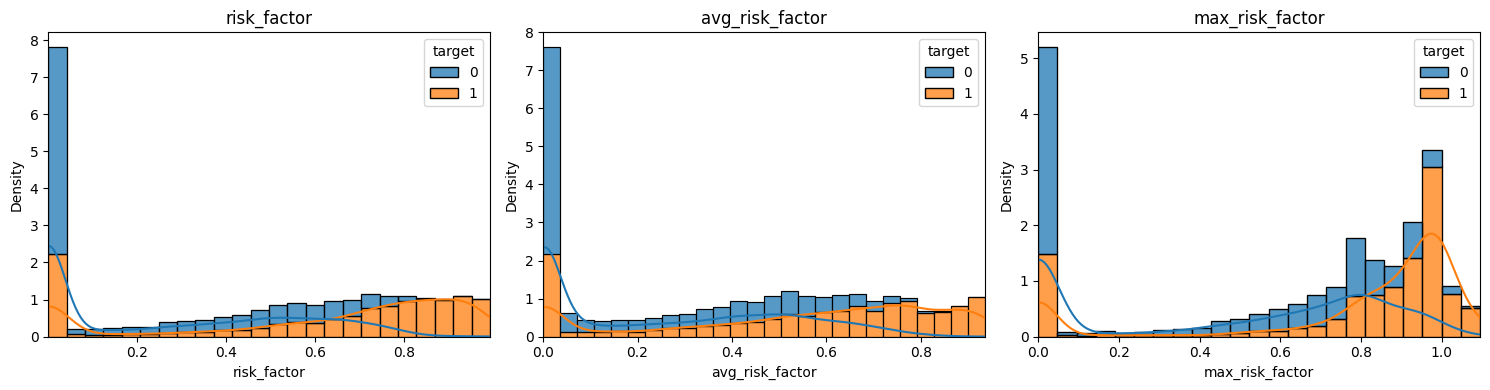

In [77]:
# se estudiará la distribución de las 3 variables más correlacionadas con 'target'
top_3_correlated_variables = correlations_sorted.index[1:4]
def plot_distributions_grid_stacked(df, max_plots_per_row=3, hue=None, normalize=False, clip_percentiles=(1, 99)):
    """
    Plots a grid of histograms with stacked bars and overlaid KDE lines for each column in a DataFrame.
    Each plot has its own scale for both X and Y axes.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data to plot.
    - max_plots_per_row (int): Maximum number of plots per row.
    - hue (str): Column name to use for coloring the plots (optional).
    - normalize (bool): Whether to normalize histograms for comparison.
    - clip_percentiles (tuple): Percentiles to clip the data for better visualization.
    """
    # Calculate the grid dimensions
    num_columns = len(df.columns)
    if hue in df.columns:
        num_columns -= 1  # Exclude hue column from plotting
    
    num_rows = int(np.ceil(num_columns / max_plots_per_row))
    
    fig, axes = plt.subplots(num_rows, max_plots_per_row, figsize=(5 * max_plots_per_row, 4 * num_rows))
    axes = axes.flatten()  # Flatten to make indexing easier
    
    columns_to_plot = [col for col in df.columns if col != hue]
    
    # Plot each column
    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        # Clip data to remove outliers
        lower, upper = np.percentile(df[column], clip_percentiles)
        clipped_data = df[(df[column] >= lower) & (df[column] <= upper)]
        
        if hue and hue in df.columns:
            # Plot stacked histogram
            sns.histplot(data=clipped_data, x=column, hue=hue, kde=False, 
                         stat='density' if normalize else 'count', ax=ax, element="bars", multiple="stack")
            # Add overlaid KDE lines
            sns.kdeplot(data=clipped_data, x=column, hue=hue, ax=ax, common_norm=normalize, legend=False)
        else:
            sns.histplot(clipped_data[column], kde=True, stat='density' if normalize else 'count', ax=ax)
        
        ax.set_title(column)
        ax.set_xlim(lower, upper)  # Set x-axis limits to clipped range
    
    # Remove unused subplots
    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

to_plot_cols = top_3_correlated_variables.tolist() + ['target']
plot_distributions_grid_stacked(df_t0_columns_dropped[to_plot_cols], max_plots_per_row=3, hue='target', normalize=True)

## Resumen y conclusiones

Hecho el Análisis Exploratorio de Datos se obtuvo las siguientes observaciones:
 
- Se debe eliminar columnas que no aportan información relevantes, entre ellas las del tipo timestamp o identificadores.

- No hay nulos ni blancos en X_t0, por lo que en esta instancia no es necesario realizar una imputación o filtrado de datos.

- El desbalance de clase en la columna target es despreciable en el dataset inicial "X_t0" por lo que no se considerará que esta variable esté desbalanceada.

- No hay columnas categóricas, por lo que no será necesario implementar en el preprocesamiento pasos relacionados a esto, o bien, implementar modelos con cierta especialización en este tipo de variables.

- Existen diversas variables que concentran sus valores en 0, lo que no aportar información relevante por lo que estas se eliminarán. 

- Las variables no muestran una distribución normal, por lo que al escalarlas no se utilizará StandarScaler si no MinMaxScaler en todas las columnas.

- No existen pares de columnas que tengan una alta correlación, por lo que estas no son redundantes entre sí.

- No existen columnas con una alta correlación a la variable target.
 

Con esto en consideración, se concluye el análisis exploratorio de datos.


### **2.2 Preprocesamiento de Datos**

Luego de un primer acercamiento a los datos, se procede a realizar un preprocesamiento de estos.


In [78]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())   # se escoge minmax scaler dado que los datos no tienen una distribución normal en ninguna feature

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.drop('target'))
    ]
)


In [79]:
from sklearn.model_selection import train_test_split

X = df_t0_columns_dropped.drop(columns='target')
y = df_t0_columns_dropped['target']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y_t0, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((31007, 68), (6644, 68), (6645, 68))

In [80]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

y_train = np.array(y_train).ravel()
y_val = np.array(y_val).ravel()
y_test = np.array(y_test).ravel()

## **3. Modelamiento**
### **3.1 Baseline** 
Se implementa un baseline, para ello se elige Decision Tree  y se crea una función que englobe los Pipelines y retorne métricas de interés. En lo siguiente, consideraremos como métrica objetivo AUC porque se trabaja un problema de clasificación binaria donde es importante distinguir adecuadamente ambas clases por igual.


In [81]:
import os
import pickle
from typing import Callable, List, Union

import mlflow
import optuna
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

# FunctionTransformer para dropear columnas
def drop_columns(X, features_to_drop):
    return X.drop(columns=features_to_drop, errors="ignore")


# FunctionTransformer para verificar y ordenar columnas
def verify_and_order_columns(X, features_order):
    missing_columns = [col for col in features_order if col not in X.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")
    return X[features_order]


def create_preprocessor(numeric_features, scaler, use_pca, pca_components):
    """Crea el preprocesador basado en las características numéricas,
    incluyendo los FunctionTransformers para dropear y ordenar columnas."""

    FEATURES_TO_DROP = [
        "borrow_block_number",
        "wallet_address",
        "borrow_timestamp",
        "first_tx_timestamp",
        "last_tx_timestamp",
        "risky_first_tx_timestamp",
        "risky_last_tx_timestamp",
        "unique_borrow_protocol_count",
        "unique_lending_protocol_count",
        "incoming_tx_count",
        "net_incoming_tx_count",
        "avg_gas_paid_per_tx_eth",
        "total_gas_paid_eth",
        "outgoing_tx_count",
        "risky_tx_count",
        "withdraw_deposit_diff_if_positive_eth",
        "borrow_amount_avg_eth",
        "total_balance_eth",
        "total_available_borrows_eth",
        "total_collateral_eth",
        "total_collateral_avg_eth",
        "total_available_borrows_avg_eth",
        "max_eth_ever",
        "min_eth_ever",
        "outgoing_tx_avg_eth",
        "incoming_tx_avg_eth",
        "risky_first_last_tx_timestamp_diff",
        "risky_sum_outgoing_amount_eth",

        
    ]

    FEATURES_ORDER = [
        "wallet_age",
        "risky_unique_contract_count",
        "outgoing_tx_sum_eth",
        "incoming_tx_sum_eth",
        "risk_factor",
        "risk_factor_above_threshold_daily_count",
        "avg_weighted_risk_factor",
        "avg_risk_factor",
        "max_risk_factor",
        "borrow_amount_sum_eth",
        "borrow_count",
        "repay_amount_sum_eth",
        "repay_amount_avg_eth",
        "repay_count",
        "borrow_repay_diff_eth",
        "deposit_count",
        "deposit_amount_sum_eth",
        "time_since_first_deposit",
        "withdraw_amount_sum_eth",
        "liquidation_count",
        "time_since_last_liquidated",
        "liquidation_amount_sum_eth",
        "market_adx",
        "market_adxr",
        "market_apo",
        "market_aroonosc",
        "market_aroonup",
        "market_atr",
        "market_cci",
        "market_cmo",
        "market_correl",
        "market_dx",
        "market_fastk",
        "market_fastd",
        "market_ht_trendmode",
        "market_linearreg_slope",
        "market_macd_macdext",
        "market_macd_macdfix",
        "market_macd",
        "market_macdsignal_macdext",
        "market_macdsignal_macdfix",
        "market_macdsignal",
        "market_max_drawdown_365d",
        "market_natr",
        "market_plus_di",
        "market_plus_dm",
        "market_ppo",
        "market_rocp",
        "market_rocr",
    ]

    if scaler is None:
        scaler = MinMaxScaler()

    # Dropear columnas
    drop_transformer = FunctionTransformer(
        drop_columns, kw_args={"features_to_drop": FEATURES_TO_DROP}
    )

    # Verificar y ordenar columnas
    order_transformer = FunctionTransformer(
        verify_and_order_columns, kw_args={"features_order": FEATURES_ORDER}
    )

    # Crear pipeline para las características numéricas
    numeric_transformer_steps = [
        ("dropper", drop_transformer),
        ("orderer", order_transformer),
        ("scaler", scaler)
    ]
    if use_pca:
        numeric_transformer_steps.append(("pca", PCA(n_components=pca_components)))
    
    numeric_transformer = Pipeline(steps=numeric_transformer_steps)

    # Crear el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
        ]
    )
    return preprocessor

def create_pipeline(
    model: BaseEstimator,
    preprocessor: ColumnTransformer,
):
    return Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])


def optimize_hyperparameters(
    model: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, np.ndarray],
    get_optuna_params: Callable,
    experiment_name: str,
    n_trials: int = 50,
    direction: str = "maximize",
):
    def objective(trial: optuna.Trial):
        run_name = f"trial_{trial.number}_optimization"
        with mlflow.start_run(run_name=run_name, nested=True):
            optuna_params = get_optuna_params(trial)
            model.set_params(**optuna_params)
            mlflow.log_params(optuna_params)
            
            model.fit(X_train, y_train)

            # Optimizamos sobre el AUC ROC
            y_proba_pred = model.predict_proba(X_train)[:, 1]
            roc_auc = roc_auc_score(y_train, y_proba_pred)
            mlflow.log_metric("roc_auc", roc_auc)
            
            return roc_auc

    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name="optuna_study"):
        study = optuna.create_study(direction=direction)
        study.optimize(objective, n_trials=n_trials)
        mlflow.end_run()

    # Log best parameters in a separate run
    with mlflow.start_run(run_name="best_params", nested=False):
        mlflow.log_params(study.best_params)

    return study.best_params


def evaluate_model(y_true, y_pred, y_pred_proba=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="binary"),
        "recall": recall_score(y_true, y_pred, average="binary"),
        "f1_score": f1_score(y_true, y_pred, average="binary"),
        "roc_auc": (
            roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None
        ),
    }
    print(f"Métricas del modelo:")
    for k, v in metrics.items():
        print(f"    {k}: {v}")
    print(f"Confusion matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"Classification report:\n{classification_report(y_true, y_pred)}")
    return metrics


def log_metrics(metrics: dict, prefix: str):
    mlflow.log_metrics({f"{prefix}_{k}": v for k, v in metrics.items()})


def save_model(pipeline: Pipeline, save_model_path: str):
    with open(save_model_path, "wb") as f:
        pickle.dump(pipeline, f)


def train_model(
    model: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, np.ndarray],
    X_val: pd.DataFrame,
    y_val: Union[pd.Series, np.ndarray],
    numeric_features: Union[pd.Index, List[str]],
    experiment_name: str,
    save_model_path: str = None,
    scaler=None,
    use_pca=False,
    pca_components=50,
    optimize: bool = False,
    get_optuna_params: Callable = None,
    n_trials: int = 50,
):
    mlflow.set_experiment(experiment_name)

    preprocessor = create_preprocessor(
        numeric_features, scaler, use_pca, pca_components
    )

    if optimize and get_optuna_params:
        best_params = optimize_hyperparameters(
            model, X_train, y_train, get_optuna_params, experiment_name, n_trials
        )
        mlflow.end_run()
        model.set_params(**best_params)

    pipeline = create_pipeline(model, preprocessor)

    with mlflow.start_run(run_name="best_params_training"):
        pipeline.fit(X_train, y_train)

        preprocessor_fitted = pipeline["preprocessor"]

        # Log metrics
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)

        if hasattr(model, "predict_proba"):
            y_train_proba_pred = pipeline.predict_proba(X_train)[:, 1]
            y_val_proba_pred = pipeline.predict_proba(X_val)[:, 1]
        else:
            y_train_proba_pred = None
            y_val_proba_pred = None

        print("Evaluación del modelo en el conjunto de entrenamiento:")
        train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba_pred)
        print("Evaluación del modelo en el conjunto de validación:")
        val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba_pred)

        log_metrics(train_metrics, "train")
        log_metrics(val_metrics, "val")

        if save_model_path:
            # Save model and preprocessor
            save_model(pipeline, save_model_path)

    return pipeline


def retrain_model(
    pipeline_or_path: Union[str, Pipeline],
    X: pd.DataFrame,
    y: Union[pd.Series, np.ndarray],
    fun_to_update_model: Callable,
    save_model_path: str,
    test_size: float = 0.2,
    random_state: int = 42,
    optimize: bool = False,
    get_optuna_params: Callable = None,
    n_trials: int = 50,
):
    if isinstance(pipeline_or_path, str):
        with open(pipeline_or_path, "rb") as f:
            pipeline = pickle.load(f)
    else:
        pipeline = pipeline_or_path

    preprocessor = pipeline.named_steps["preprocessor"]
    model: BaseEstimator = pipeline.named_steps["classifier"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_train_transformed = preprocessor.transform(X_train)

    if optimize and get_optuna_params:
        best_params = optimize_hyperparameters(
            model,
            X_train_transformed,
            y_train,
            get_optuna_params,
            "retraining_optimization",
            n_trials,
        )
        model.set_params(**best_params)

    model = fun_to_update_model(model, X_train_transformed, y_train)

    pipeline = create_pipeline(model, preprocessor)
    save_model(pipeline, save_model_path)

    X_test_transformed = preprocessor.transform(X_test)
    y_pred = model.predict(X_test_transformed)
    y_pred_proba = (
        model.predict_proba(X_test_transformed)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )

    print("Evaluación en el conjunto de prueba:")
    evaluate_model(y_test, y_pred, y_pred_proba)

    return pipeline

In [82]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_pipe, _ = train_model(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic Decision Tree",
    numeric_features=train_numeric_features,
)

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 1.0
    precision: 1.0
    recall: 1.0
    f1_score: 1.0
    roc_auc: 1.0
Confusion matrix:
[[15148     0]
 [    0 15859]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15148
           1       1.00      1.00      1.00     15859

    accuracy                           1.00     31007
   macro avg       1.00      1.00      1.00     31007
weighted avg       1.00      1.00      1.00     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.8202889825406382
    precision: 0.822599531615925
    recall: 0.8269570335491465
    f1_score: 0.8247725271499853
    roc_auc: 0.8201328605823367
Confusion matrix:
[[2640  606]
 [ 588 2810]]
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      3246
           1       0.82  

### **3.2 Modelos de Machine Learning**

Hecho el baseline, se implementará Random Forest, XGBoost, CatBoost y LGBoost.

- Random Forest: Es un modelo de basado en árboles de decisión que utiliza aglomerativamente el conocimiento obtenido de cada uno. Cada árbol entrena sobre una muestra random del conjunto de datos y se utiliza una selección aleatoria de características para hacer la división de nodos. Los hiperparámetros iniciales de este modelo son `n_estimators` que corresponde al número de árboles por bosque, que por docente son 100. `max_depth` que es la profundidad máxima de los árboles que a priori es `None`, lo que quiere decir que los nodos se expanden hasta quetodas las hojas son puras o contienen menos muestras que `min_samples_split`, este parámetro corresponde a la cantidad mínima de muestras requeridas para dividir un nodo interno, su valor por defecto es 2. 
`min_samples_leaf` es el número mínimo de muestras requeridas para que se considere hoja, su valor por defecto es setado como 1,


- XGBoost: es un modelo basado en árboles de decisión que utiliza boosting mediante un entrenamiento secuencial de modelos con gradientes, se caracteriza por ser de rápido tiempo de ejecución. Entre los hiperpárametros del modelo se encuentran `n_estimators` que se ajusta igualmente que en RandomForest, `max_depth` es el mismo hiperparámetro descrito anteriormente sólo que en este modelo su valor por defecto es $6$. Otros hiperparámetros que se ajustan por defecto son `learning_rate` que es la tasa de aprendizaje que ajusta la contribución de cada árbol, su valor por defecto es $0.1$, `subsample` es la proporción se muestras utilizadas para contruir cada árbol y su valor por defecto es $1.0$, otro hiperparámetro importante es `reg_alpha` que es la regularización L1 ajustada por defecto como desactivada y en cambio se tiene activada `reg_lambda` que es la regularización L2 que es la que se implementa por defecto.

- LGBoost: Es un modelo similar a XGBoost en el sentido de usar boosting, solo que lo hace sobre histogramas, es especialmente útil para datos de gran embergadura que requieran un entrenamiento rápido. Sus hiperparametros seteados de por defecto son `n_estimators` (100), `learning_rate` (0.1), `max_depth` (-1, sin límite), `num_leaves` (31), `lambda_l1` (0, i.e desactivado), `lambda_l2` (0, i.e desactivado) que se ajustan por defecto con los valores dados en los paréntesis.


In [83]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pipe, _ = train_model(
    model=RandomForestClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic Random Forest",
    numeric_features=train_numeric_features
)

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 1.0
    precision: 1.0
    recall: 1.0
    f1_score: 1.0
    roc_auc: 1.0
Confusion matrix:
[[15148     0]
 [    0 15859]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15148
           1       1.00      1.00      1.00     15859

    accuracy                           1.00     31007
   macro avg       1.00      1.00      1.00     31007
weighted avg       1.00      1.00      1.00     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.8845574954846478
    precision: 0.9180171591992373
    recall: 0.8502060035314891
    f1_score: 0.8828113063407181
    roc_auc: 0.9511507258265436
Confusion matrix:
[[2988  258]
 [ 509 2889]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      3246
           1       0.92 

#### **XGBoost**

In [84]:
from xgboost import XGBClassifier

# Entrenar el modelo con XGBoost
xgboost_pipe = train_model(
    model=XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic XGBoost",
    numeric_features=train_numeric_features
)

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 0.9327571193601445
    precision: 0.9728134010709872
    recall: 0.8934989595813103
    f1_score: 0.9314708299096138
    roc_auc: 0.9859977015897273
Confusion matrix:
[[14752   396]
 [ 1689 14170]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     15148
           1       0.97      0.89      0.93     15859

    accuracy                           0.93     31007
   macro avg       0.94      0.93      0.93     31007
weighted avg       0.94      0.93      0.93     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.871312462372065
    precision: 0.9097647437963261
    recall: 0.8307828134196587
    f1_score: 0.8684817720350715
    roc_auc: 0.9425821593434868
Confusion matrix:
[[2966  280]
 [ 575 2823]]
Classification report:
              precision    recall  f1-score   support

    

#### **LGBoost**

In [85]:
from lightgbm import LGBMClassifier

lightgbm_pipe, _ = train_model(
    model=LGBMClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic LightGBM",
    numeric_features=train_numeric_features
)

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 15859, number of negative: 15148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10827
[LightGBM] [Info] Number of data points in the train set: 31007, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511465 -> initscore=0.045869
[LightGBM] [Info] Start training from score 0.045869
Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 0.8651272293353114
    precision: 0.926697361689688
    recall: 0.7995459991172205
    f1_score: 0.8584388328481484
    roc_auc: 0.9459301576693329
Confusion matrix:
[[14145  1003]
 [ 3179 12680]]
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     15148
           1       0.93      0.80      0.86     15859

    accuracy                     

Nuestra métrica objetivo es AUC, por lo que XGBoost  es el modelo que funciona mejor, esto notando que el baseline obtuvo en el conjunto de entrenamiento $1.0$ y en validation $0.82$, es decir, se sobreajustó, mientras que XGBoost mostró un desempeñó consistentemente bueno, obteniendo AUC de $0.99$ en train y $0.95$ en validation, y como muestra una diferencia menor a un 5%  (es 4%) se considera que no realizó overfitting pese a que obtiene resultados demasiado buenos en train. Esto se puede explicar dado que XGBoost implementa regularización que es una medida para prevenir el overfitting, los árboles de DecisionTree pueden ser más profundos de lo ideal llevándolo a sobre entrenarse o bien, por la naturaleza misma de los modelos en cuestión, ya que XGBoost está preparado para capturar patrones con más complejidad que DecisionTree. 
Por otra parte, DecisionTree se ejecuta más lento que XGBoost, demorando aproximadamente 8 segundos mientras que XGBoost rondea los 3 segundos, esto es relativamente esperable dado que XGBoos es conocido por ser de rápidos tiempo de ejecución. Con todo, se elige este modelo para las siguientes etapas.

### **3.3 optimización de modelo**
Se optimizará el modelo seleccionado anteriormente mediante el uso de optuna y técnicas de re entrenamiento.

Como se mencionó anteriomente, se buscará maximizar el ROC-AUC con el fin de que el modelo sea capaz de separar lo más posible ambas clases, lo que se verá reflejado en no favorecer falsos positivos o falsos negativos.

El re entrenamiento fue un proceso relativamente rápido demorando aproximadamente un minuto su ejecución con 50 trials, esto se probó en dos instancias para predecir en CodaLab, primeramente con 30 trials obteniendo un valor de AUC de 0.87 y luego se probó con 50 trials que obtuvo un desempeño relativamente menor con un AUC 0.86, un indicio de que el modelo baja su desempeño, también se probó añadiendo hiperparámetros a optimizar obteniendo los mismos resultados. Por esto, no necesariamente el modelo mejorará invirtiendo más tiempo, puede ser mejor opción escoger minuciosamente los hiperparámetros a escoger y la cantidad de trials necesarios. 

Por otra parte, el hiperparámetro que más afectó al entrenamiento fue el learning rate, seguido de max_depth y en tercera posición n_estimators, lo que hace sentido pues estos hiperparámetros son fundamentales en el funcionamiento del modelo.

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 0.9327571193601445
    precision: 0.9728134010709872
    recall: 0.8934989595813103
    f1_score: 0.9314708299096138
    roc_auc: 0.9859977015897273
Confusion matrix:
[[14752   396]
 [ 1689 14170]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     15148
           1       0.97      0.89      0.93     15859

    accuracy                           0.93     31007
   macro avg       0.94      0.93      0.93     31007
weighted avg       0.94      0.93      0.93     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.871312462372065
    precision: 0.9097647437963261
    recall: 0.8307828134196587
    f1_score: 0.8684817720350715
    roc_auc: 0.9425821593434868
Confusion matrix:
[[2966  280]
 [ 575 2823]]
Classification report:
              precision    recall  f1-score   support

    

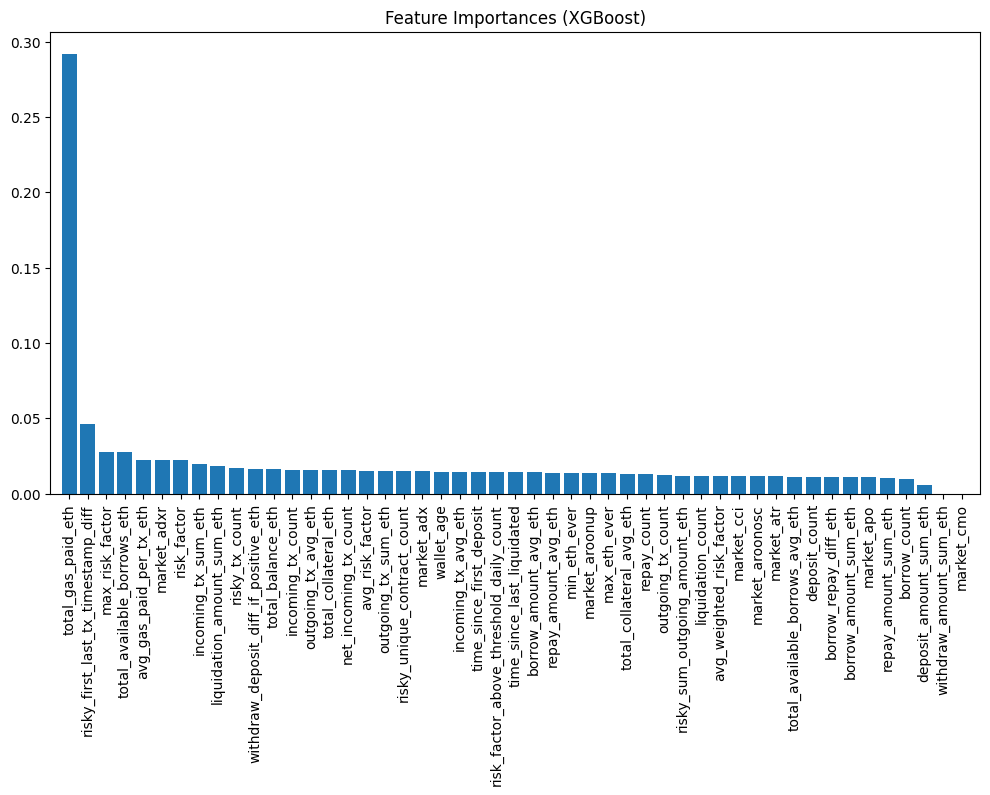

In [86]:
#funcionamiento general y breve comprobación de que el modelo tenga sentido en cuánto a su interpretabilidad
xgboost_pipe_interpret= train_model(
    model= XGBClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="XGBoost: n_estimators=100, random_state=42",
    numeric_features=train_numeric_features
)
et_model = xgboost_pipe_interpret.named_steps["classifier"]
importances = et_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (XGBoost)")
preprocessed_X_train = xgboost_pipe_interpret.named_steps["preprocessor"].transform(X_train)

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

In [87]:
X_t1_iter_1 = pd.read_parquet(DATA_PATH + "X_t1_new.parquet").reset_index(drop=True)
y_t1_iter_1 = pd.read_parquet(DATA_PATH + "y_t1.parquet").reset_index(drop=True)

df_t1_iter_1 = pd.concat([X_t1_iter_1, y_t1_iter_1], axis=1)

df_t1_iter_1_columns_dropped = df_t1_iter_1.drop(columns=columns_to_drop, inplace=False)

X_t1_iter_1 = df_t1_iter_1_columns_dropped.drop(columns='target')
y_t1_iter_1 = df_t1_iter_1_columns_dropped['target']

X_t1_iter_1.head()

,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,...,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr
0,41337993.0,12,14,-2,0.015177,0.001084,1,2,0,17.560335,...,1.459793,3.971377,4.14544,-0.736622,4.385686,19.552328,24.502158,-1.672639,0.007081,1.007081
1,27637657.0,189,217,-28,1.162723,0.005358,13,3,521720,113.787495,...,1.459793,3.971377,4.14544,-0.736622,4.385686,19.552328,24.502158,-1.672639,0.007081,1.007081
2,96789742.0,27,32,-5,0.270085,0.008440,3,1,18937,170.000000,...,1.459793,3.971377,4.14544,-0.736622,4.385686,19.552328,24.502158,-1.672639,0.007081,1.007081
3,29496551.0,171,228,-57,0.206756,0.000911,0,0,0,0.000000,...,1.459793,3.971377,4.14544,-0.736622,4.385686,19.552328,24.502158,-1.672639,0.007081,1.007081
4,1339.0,4,3,1,0.010250,0.003417,0,0,0,0.000000,...,1.459793,3.971377,4.14544,-0.736622,4.385686,19.552328,24.502158,-1.672639,0.007081,1.007081


In [88]:
# splits de nuevos datos
X_train_iter_1, X_val_iter_1, y_train_iter_1, y_val_iter_1 = train_test_split(
    X_t1_iter_1, y_t1_iter_1, train_size=0.7, stratify=y_t1_iter_1, random_state=42
)

In [89]:
from sklearn.preprocessing import MinMaxScaler

# Primero el entrenamiento normal
model_final = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgboost_pipe_retrain = train_model(
    model=model_final,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Modelo Incremental",
    numeric_features=train_numeric_features,
    save_model_path="xgboost_model_pre_retrain.pkl",
)

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 0.9327571193601445
    precision: 0.9728134010709872
    recall: 0.8934989595813103
    f1_score: 0.9314708299096138
    roc_auc: 0.9859977015897273
Confusion matrix:
[[14752   396]
 [ 1689 14170]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     15148
           1       0.97      0.89      0.93     15859

    accuracy                           0.93     31007
   macro avg       0.94      0.93      0.93     31007
weighted avg       0.94      0.93      0.93     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.871312462372065
    precision: 0.9097647437963261
    recall: 0.8307828134196587
    f1_score: 0.8684817720350715
    roc_auc: 0.9425821593434868
Confusion matrix:
[[2966  280]
 [ 575 2823]]
Classification report:
              precision    recall  f1-score   support

    

In [90]:
def function_to_retrain_XGB(model, X_train, y_train):
    import xgboost as xgb
    model.save_model("tmp_model.model")
    xgb.train(
        model.get_params(),
        xgb.DMatrix(X_train, label=y_train),
        num_boost_round=10,
        xgb_model="tmp_model.model",
    )
    os.remove("tmp_model.model")
    return model

In [91]:
retrained_pipe = retrain_model(
    pipeline_or_path="xgboost_model_pre_retrain.pkl",
    X=X_t1_iter_1,
    y=y_t1_iter_1,
    fun_to_update_model=function_to_retrain_XGB,
    save_model_path="xgboost_model_post_retrain.pkl",
    test_size=0.2,
    random_state=42,
    optimize=True,
    get_optuna_params=lambda trial: {
        "max_depth": trial.suggest_int("max_depth", 1, 32),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 32),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
    },
    n_trials=5,
)

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

Evaluación en el conjunto de prueba:
Métricas del modelo:
    accuracy: 0.8172548724508992
    precision: 0.8489714664897147
    recall: 0.6323645709766706
    f1_score: 0.7248314543085378
    roc_auc: 0.8779378682438614
Confusion matrix:
[[15324  1138]
 [ 3719  6397]]
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     16462
           1       0.85      0.63      0.72     10116

    accuracy                           0.82     26578
   macro avg       0.83      0.78      0.79     26578
weighted avg       0.82      0.82      0.81     26578



## **3.4 Interpretabilidad**
Se analizará el funcionamiento del modelo optimizado mediante el uso de `SHAP`

In [92]:
import os
import matplotlib.pyplot as plt

# Crear directorio para guardar los resultados
output_dir = "shap_results_xgb"
os.makedirs(output_dir, exist_ok=True)

In [93]:
import shap
model = xgboost_pipe_retrain.named_steps["classifier"] 
X_val_transformed = xgboost_pipe_retrain.named_steps['preprocessor'].transform(X_val_iter_1)


In [94]:
explainer = shap.TreeExplainer(model)
exp = explainer(X_val_transformed)

In [95]:
FEATURES_ORDER = [
        "wallet_age",
        "risky_unique_contract_count",
        "outgoing_tx_sum_eth",
        "incoming_tx_sum_eth",
        "risk_factor",
        "risk_factor_above_threshold_daily_count",
        "avg_weighted_risk_factor",
        "avg_risk_factor",
        "max_risk_factor",
        "borrow_amount_sum_eth",
        "borrow_count",
        "repay_amount_sum_eth",
        "repay_amount_avg_eth",
        "repay_count",
        "borrow_repay_diff_eth",
        "deposit_count",
        "deposit_amount_sum_eth",
        "time_since_first_deposit",
        "withdraw_amount_sum_eth",
        "liquidation_count",
        "time_since_last_liquidated",
        "liquidation_amount_sum_eth",
        "market_adx",
        "market_adxr",
        "market_apo",
        "market_aroonosc",
        "market_aroonup",
        "market_atr",
        "market_cci",
        "market_cmo",
        "market_correl",
        "market_dx",
        "market_fastk",
        "market_fastd",
        "market_ht_trendmode",
        "market_linearreg_slope",
        "market_macd_macdext",
        "market_macd_macdfix",
        "market_macd",
        "market_macdsignal_macdext",
        "market_macdsignal_macdfix",
        "market_macdsignal",
        "market_max_drawdown_365d",
        "market_natr",
        "market_plus_di",
        "market_plus_dm",
        "market_ppo",
        "market_rocp",
        "market_rocr",
    ]

X_val_transformed = pd.DataFrame(X_val_transformed, columns= FEATURES_ORDER)

Análisis local para la observación 5:


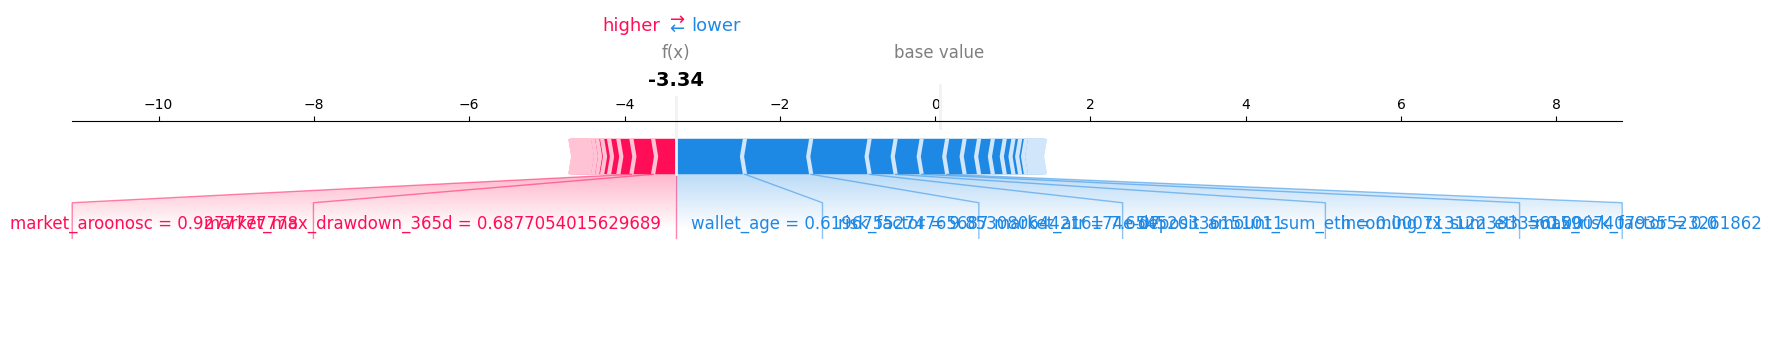

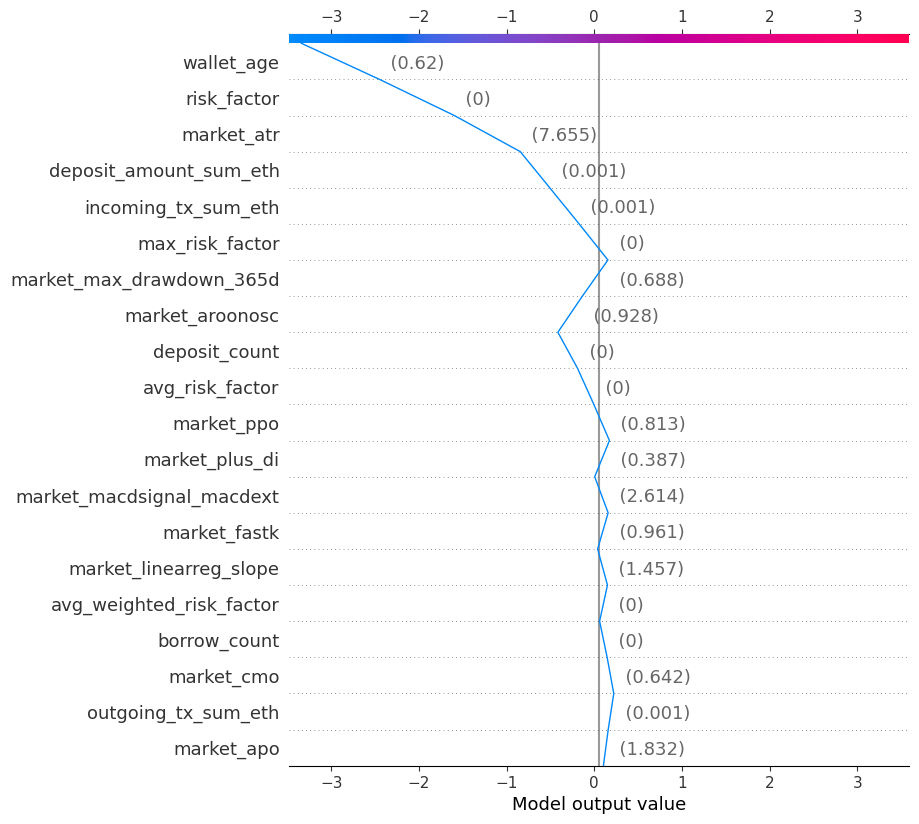

Análisis local para la observación 150:


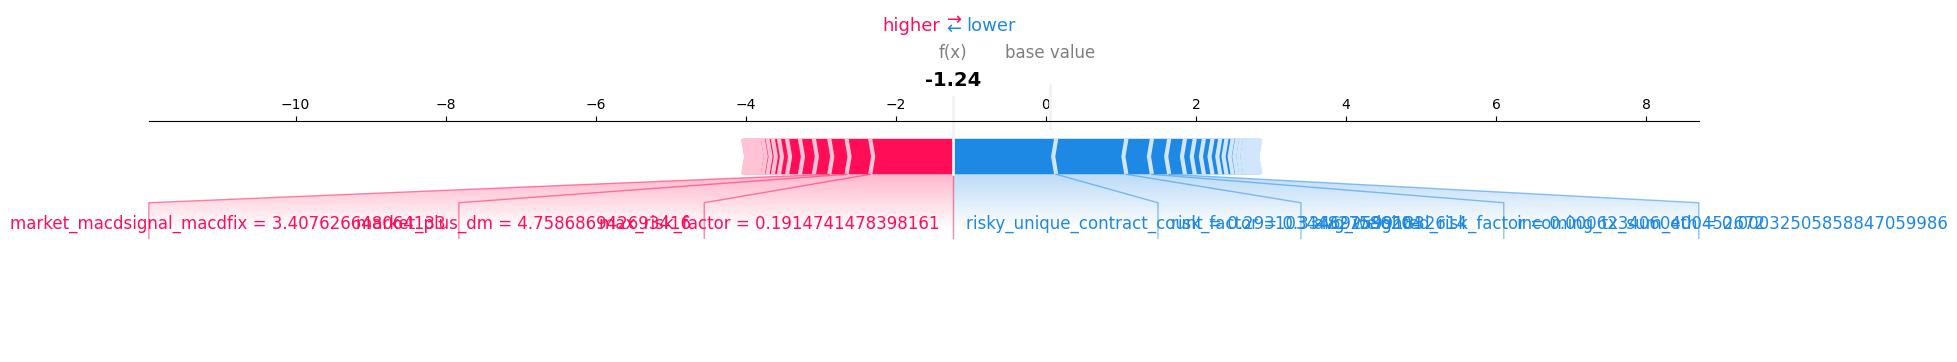

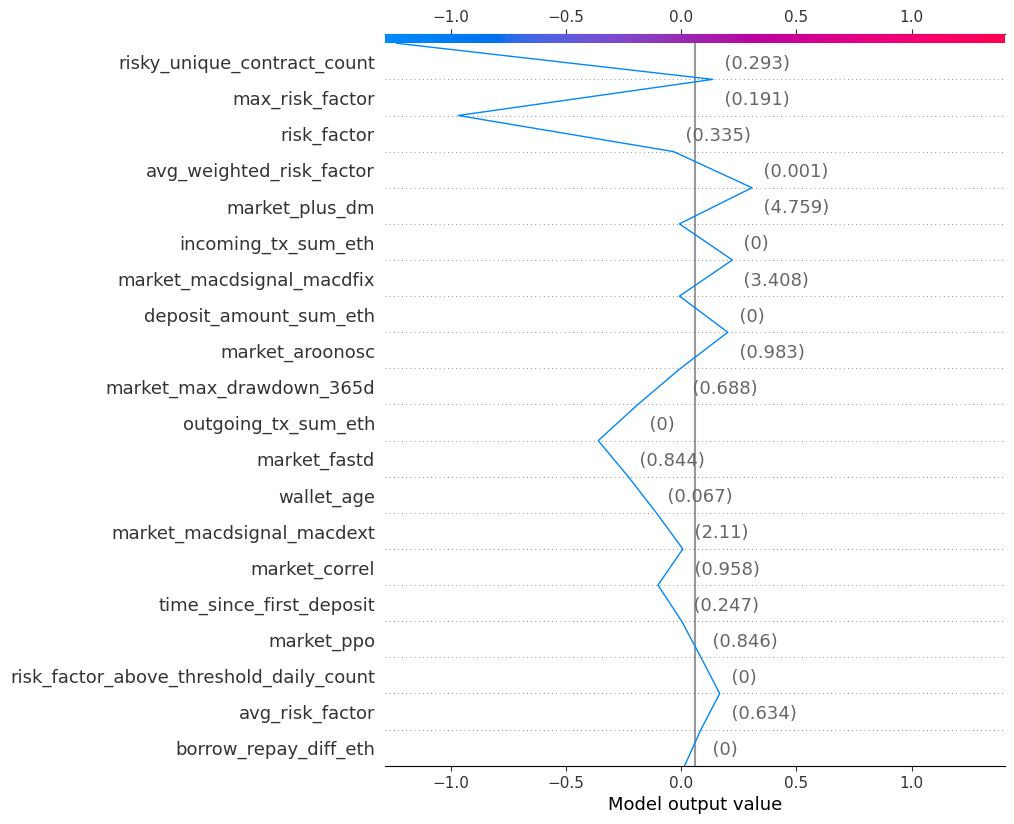

Análisis local para la observación 700:


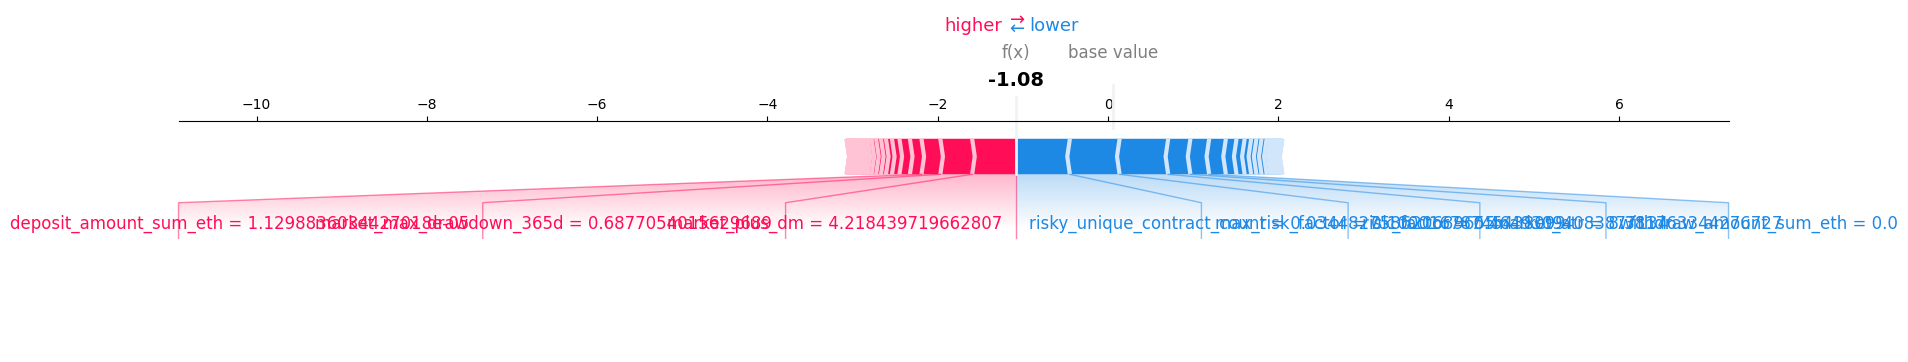

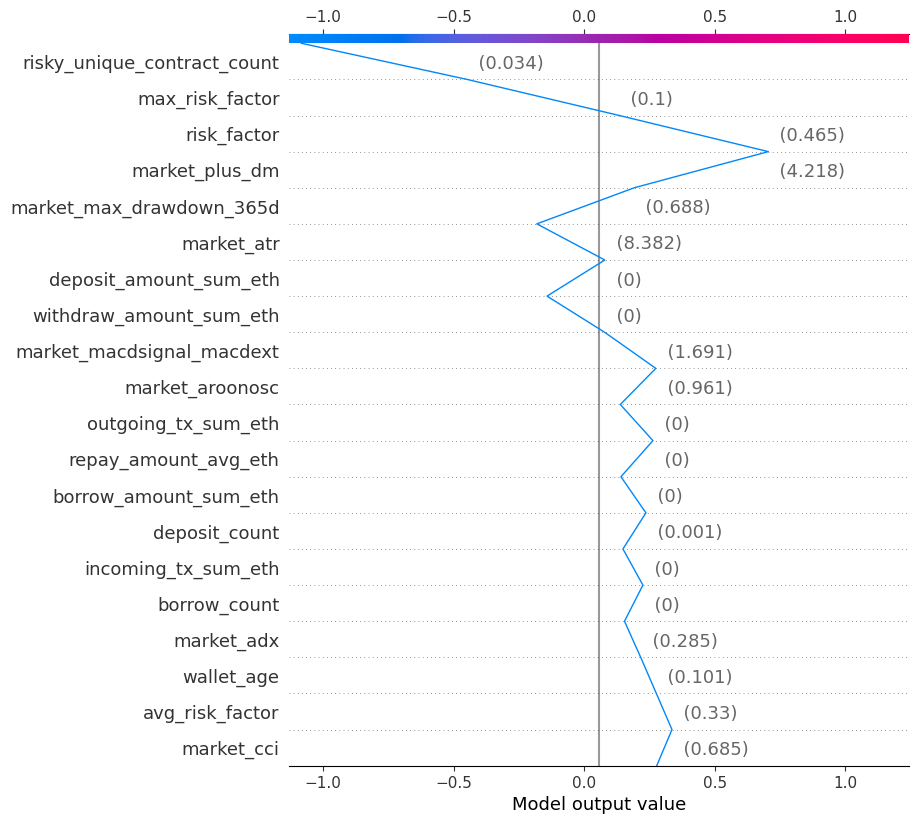

In [96]:
indices = [5, 150, 700] 

for idx in indices:
    print(f"Análisis local para la observación {idx}:")
    
    shap_values_local = exp.values[idx, :]  
    features_local = X_val_transformed.iloc[idx, :] 
    prediction = model.predict(X_val_transformed.iloc[[idx], :])  
    
    shap.force_plot(
        explainer.expected_value,
        shap_values_local,  
        features_local,  
        matplotlib=True  
    )
    
    shap.decision_plot(
        explainer.expected_value,
        shap_values_local,
        features_local,
        feature_order='importance'
    )


In [97]:
shap_values_abs = np.mean(np.abs(exp.values), axis=0)
feature_importance_names = X_val_transformed.columns[shap_values_abs.argsort()[::-1]]

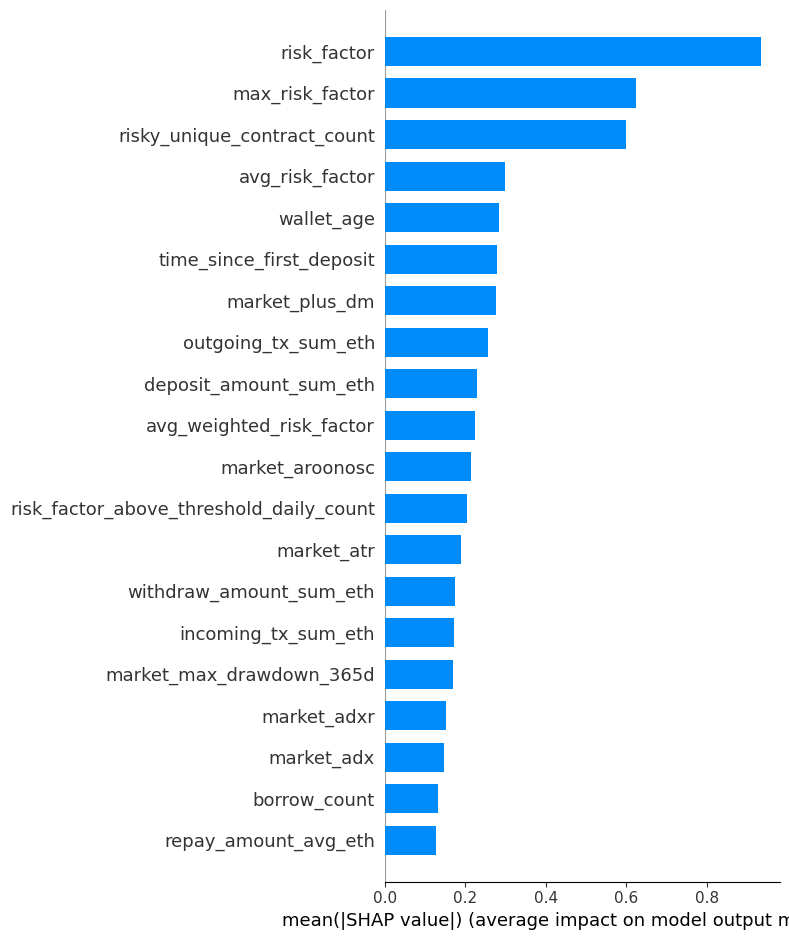

In [98]:
shap.summary_plot(exp.values, X_val_transformed, plot_type="bar")


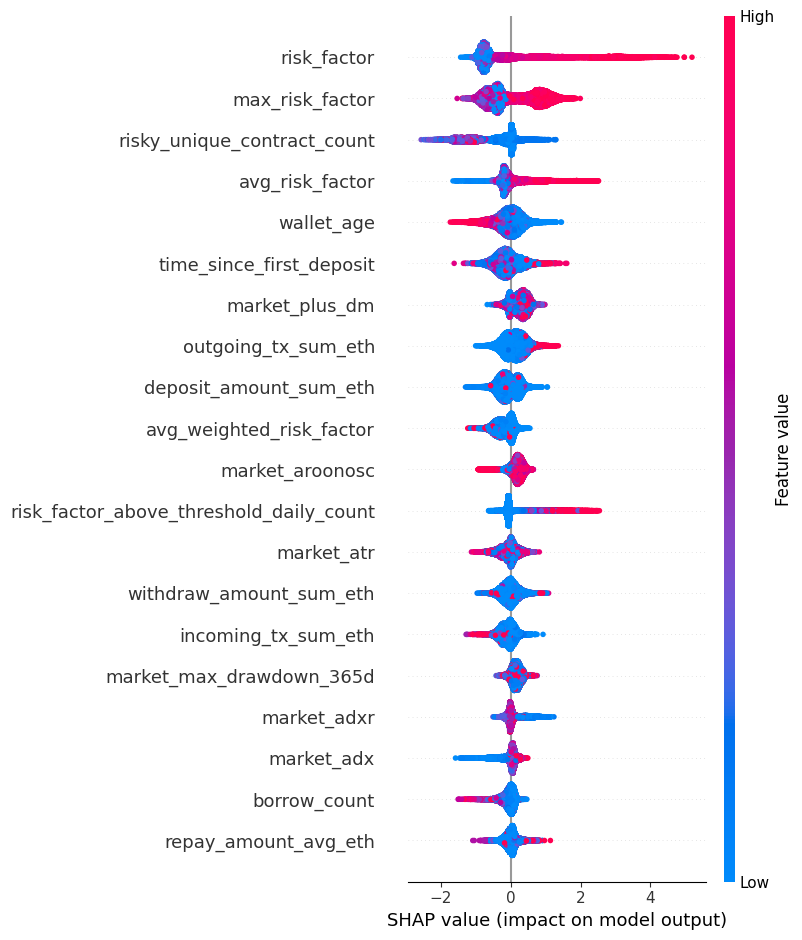

In [99]:
shap.summary_plot(exp.values, X_val_transformed)

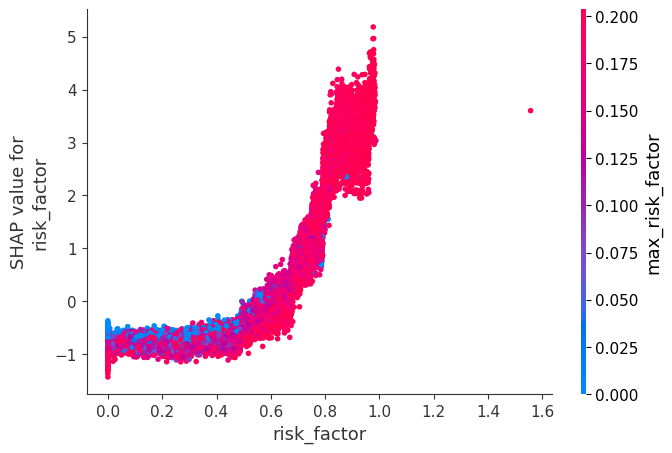

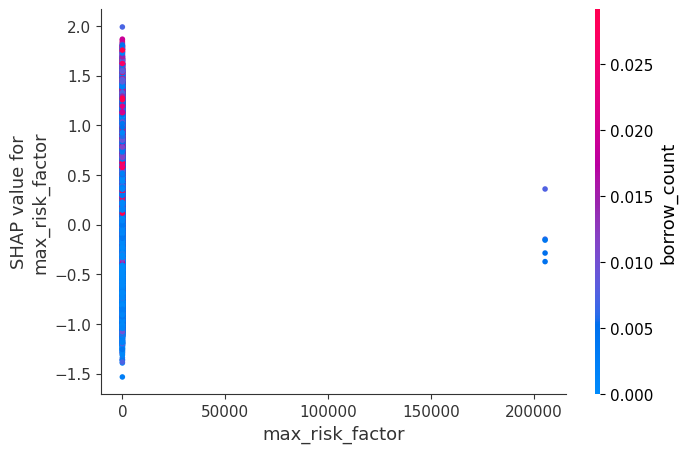

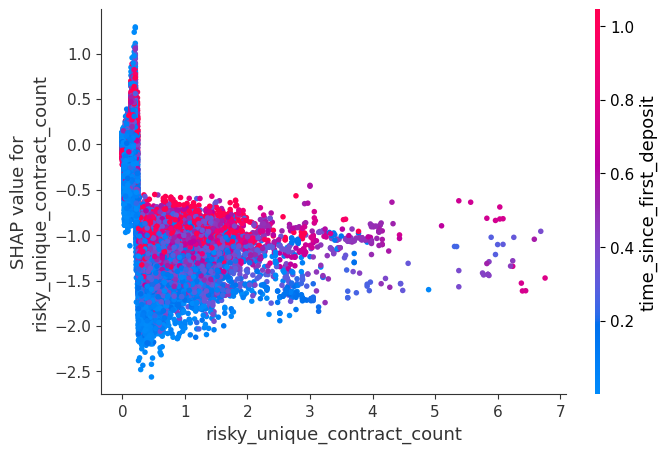

In [100]:
#veamos en más detalle las 3 features más importantes 
color = model.predict(X_val_transformed) 
for name in feature_importance_names[:3]:
    shap.dependence_plot(name, exp.values, X_val_transformed)

Se realizó gráficos para analizar la interpretabilidad local y luego global, de lo mostrado se desprende que con la variable risk_factor es la más importante para el modelo, sobre todo cuando esta alcanza sus valores más altos y para valores bajos no es tan relevante en la decisión final, lo cual hace sentido para detectar morosidad, en la misma línea se hace importante en algunas max_risk_factor, dejando ver que cuando estas variables el valor es alto, muy probablemente se vaya a tratar de un cliente que será moroso. También se observa que risky_unique_contract_count es una variable que toma importancia en los tres ejemplos locales estudiados, mostrando consistencia con las anteriormente mencionadas. Se debe notar que lo observado para la interpretabilidad local sigue siendo válido para la interpretabilidad global, mientras que no se observa tendencias no lógicas del modelo por ciertos atributos específicos, lo que lleva a comprender como el modelo está razonando respecto a las variables y como estas son razonables para el problema, se puede decir que se llegó a un buen modelo final.

## Tracking de experimentos con MLflow

Para visualizar la interfaz gráfica con el progreso de los experimentos, se debe ejecutar la siguiente celda que corre el comando `mlflow ui` en el directorio actual, y luego abrir el navegador en la dirección: `localhost:5000`.

In [101]:
#!mlflow ui

## Aplicación web

Para correr la aplicación web deben pararse en la carpeta del proyecto, y ejecutar el siguiente comando:

```
docker-compose up --build
```

Con esto, el front será accesible en la dirección `http://localhost:7860/`, y los docs del backend en `http://localhost:7888/docs`.

Cabe destacar que en el formulario que pide subir los datos manualmente, se incluyeron solo las columnas que se consideraron, ya que hay columnas consideradas identificadores que se creian innecesarias para realizar una predicción.

## Monitoreo


Se usará las siguientes funciones para detectar data dift y/o target drift, para ello, las aplicaremos sobre los datos entregados para las sucesivas entregas.
Las columas escogidas son las obtenidas a partir del análisis de interpretabilidad, es decir, es importante comprender el comportamiento de estas columnas dada su importancia al generar predicciones por el modelo.

In [102]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, mannwhitneyu, cramervonmises_2samp

def detect_drift(train_data, production_data, features, target_column=False, method='ks', alpha=0.05):
    """
    Detecta el drift entre datos de entrenamiento y de producción en función de las características proporcionadas.
    
    Parámetros:
    - train_data: DataFrame de datos de entrenamiento.
    - production_data: DataFrame de datos de producción.
    - features: Lista de características a evaluar.
    - target_column: Bool, evalúa también la columna target si es True.
    - method: Método estadístico ('ks', 'mw', 'cv').
    - alpha: Nivel de significancia para las pruebas.

    Retorna:
    - Boolean indicando si se detectó drift en las características o en la columna target (si se evalúa).
    """
    drift_detected = False

    for feature in features:
        train_feature = train_data[feature]
        prod_feature = production_data[feature]

        if method == 'ks':
            # Prueba Kolmogorov-Smirnov
            stat, p_value = ks_2samp(train_feature, prod_feature)
        elif method == 'mw':
            # Prueba Mann-Whitney U
            stat, p_value = mannwhitneyu(train_feature, prod_feature, alternative='two-sided')
        elif method == 'cv':
            # Prueba Cramér-von Mises
            result = cramervonmises_2samp(train_feature, prod_feature)
            stat, p_value = result.statistic, result.pvalue
        else:
            raise ValueError("El método especificado no es válido. Use 'ks', 'mw' o 'cv'.")

        if p_value < alpha:
            drift_detected = True
            break

    if target_column:
        target_train = train_data['target']
        target_prod = production_data['target']

        if method == 'ks':
            target_stat, target_p_value = ks_2samp(target_train, target_prod)
        elif method == 'mw':
            target_stat, target_p_value = mannwhitneyu(target_train, target_prod, alternative='two-sided')
        elif method == 'cv':
            result = cramervonmises_2samp(target_train, target_prod)
            target_stat, target_p_value = result.statistic, result.pvalue

        if target_p_value < alpha:
            return True  # Se detectó drift en la columna target

    return drift_detected

In [103]:
features_to_check = ['risk_factor', 'risky_unique_contract_count', 'market_aroonosc', 'borrow_count', 'wallet_age', 'market_cmo', 'market_adxr', 'market_ppo']

In [104]:
detect_drift(train_data = X_t0,production_data = X_t1_iter_1, features = features_to_check, method= 'cv')

True

In [105]:
y_t1_iter_1 = pd.DataFrame(y_t1_iter_1)
y_t1_iter_1 = y_t1_iter_1.rename(columns={y_t1_iter_1.columns[0]: 'target'})


In [106]:
detect_drift(train_data = y_t0,production_data = y_t1_iter_1, features = ["target"], target_column = True, method= 'cv')

True

Tenemos datadrift en ambos casos, lo que era esperado dados la bajada de rendimiento del modelo en la competencia de codalab en la primera entrega.

In [107]:
def plot_feature_distributions(data_train, data_production, features, bins=30, alpha=0.5, figsize=(8, 5), density=True):
    """
    Genera histogramas comparativos de distribuciones para un conjunto de características.

    Parámetros:
    - data_train: pd.DataFrame
        Conjunto de datos de entrenamiento.
    - data_production: pd.DataFrame
        Conjunto de datos de producción.
    - features: list
        Lista de nombres de las características a comparar.
    - bins: int, opcional (default=30)
        Número de bins para los histogramas.
    - alpha: float, opcional (default=0.5)
        Transparencia de las barras en los histogramas.
    - figsize: tuple, opcional (default=(8, 5))
        Tamaño de las figuras para los gráficos.
    - density: bool, opcional (default=True)
        Si True, las distribuciones serán normalizadas a densidad.
    
    Retorna:
    - None. Muestra los gráficos directamente.
    """
    for feature in features:
        plt.figure(figsize=figsize)
        plt.hist(data_train[feature], bins=bins, alpha=alpha, label='Train Data', density=density)
        plt.hist(data_production[feature], bins=bins, alpha=alpha, label='Production Data', density=density)
        plt.title(f"Distribuciones de {feature}")
        plt.xlabel(feature)
        plt.ylabel("Densidad" if density else "Frecuencia")
        plt.legend()
        plt.show()


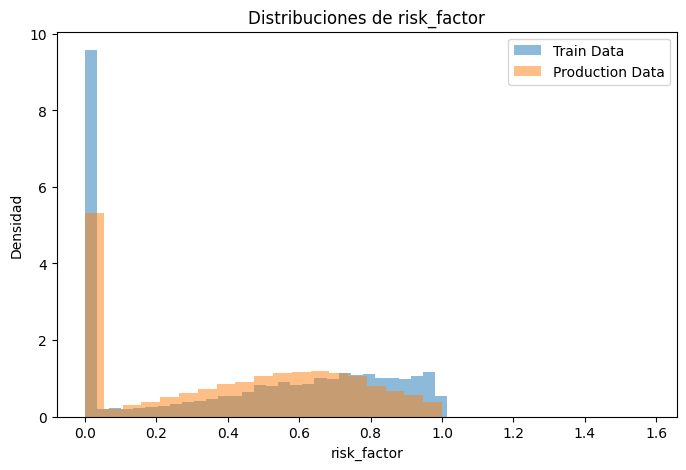

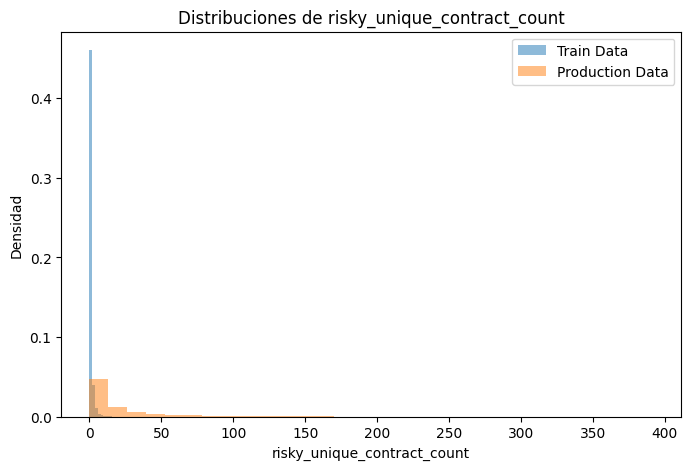

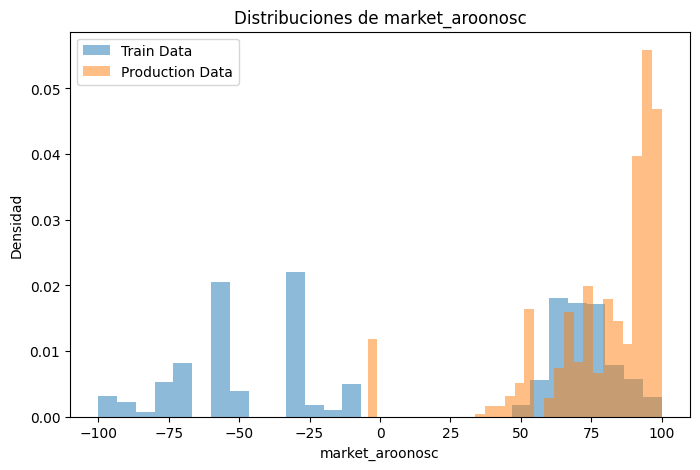

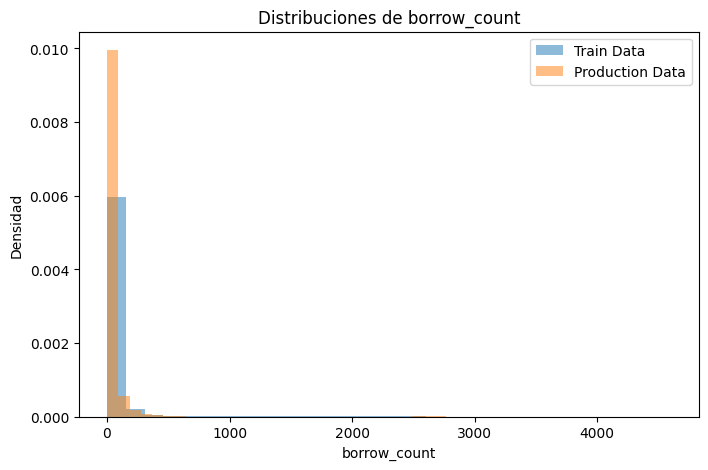

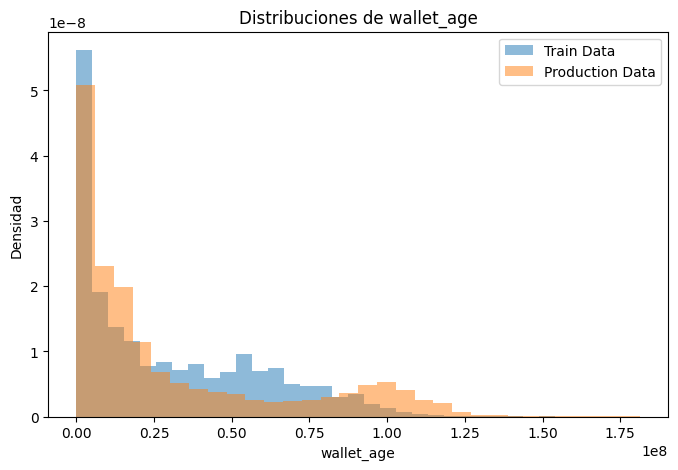

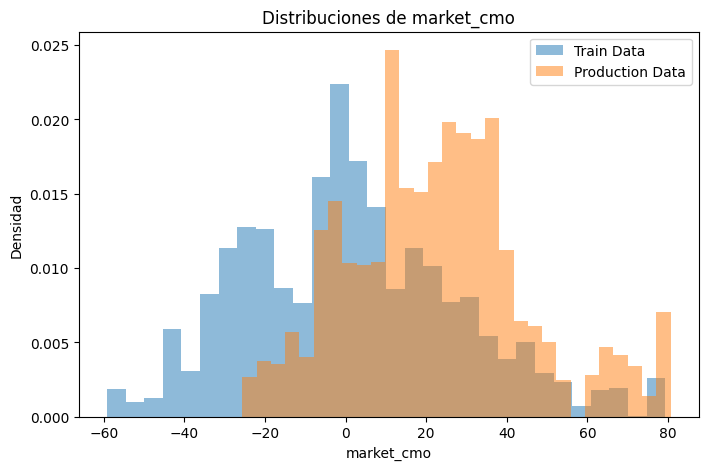

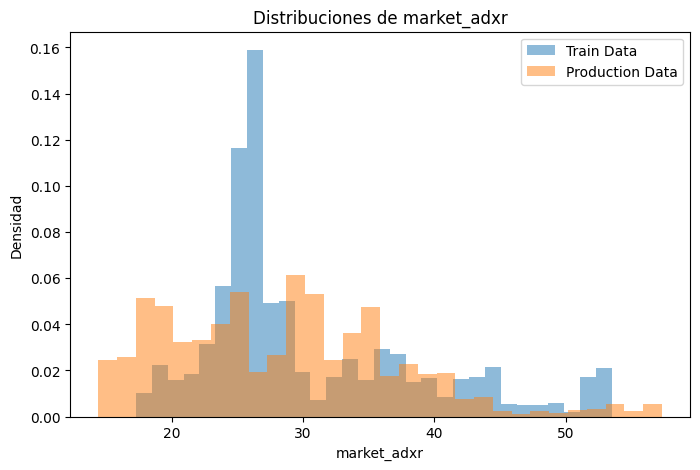

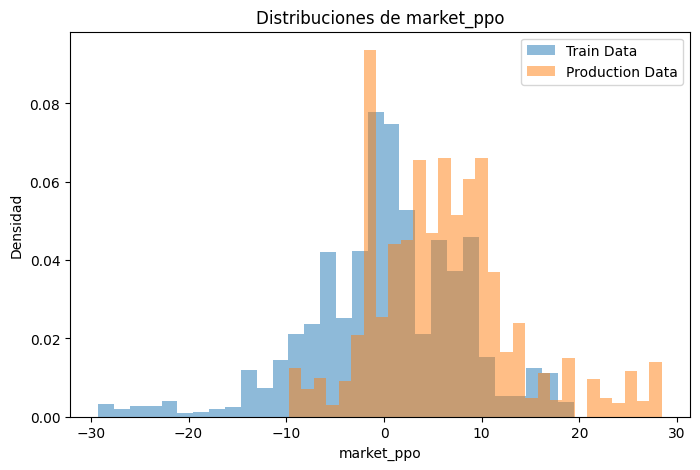

In [108]:
plot_feature_distributions(data_train=X_t0, data_production=X_t1_iter_1, features= features_to_check)

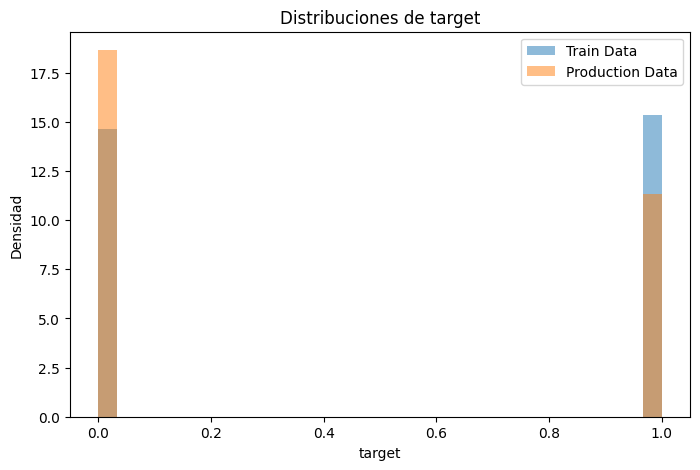

In [109]:
plot_feature_distributions(data_train=y_t0, data_production=y_t1_iter_1, features=['target'])

En todas las variables estudiadas se observa un marcado cambio en la distribución de los datos, por lo que se explica que la capacidad predictiva del modelo disminuya al entrenar con los datos de X_t0 y ser puesto en producción con los datos de X_t1.

In [110]:
X_t1_new = pd.read_parquet(DATA_PATH + "X_t1_new.parquet").reset_index(drop=True)
X_t2 = pd.read_parquet(DATA_PATH + "X_t2.parquet").reset_index(drop=True)

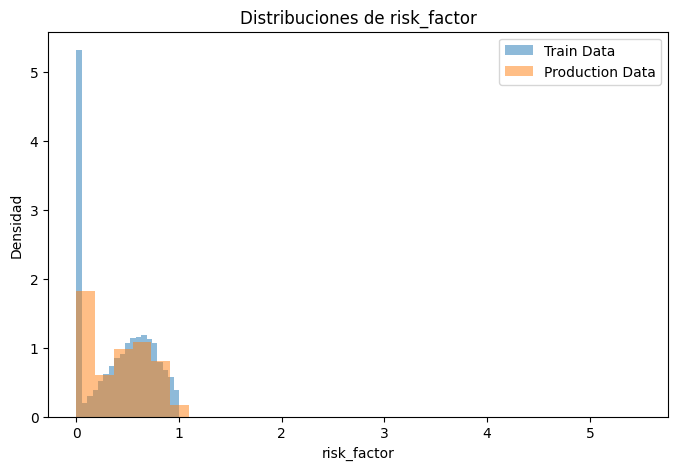

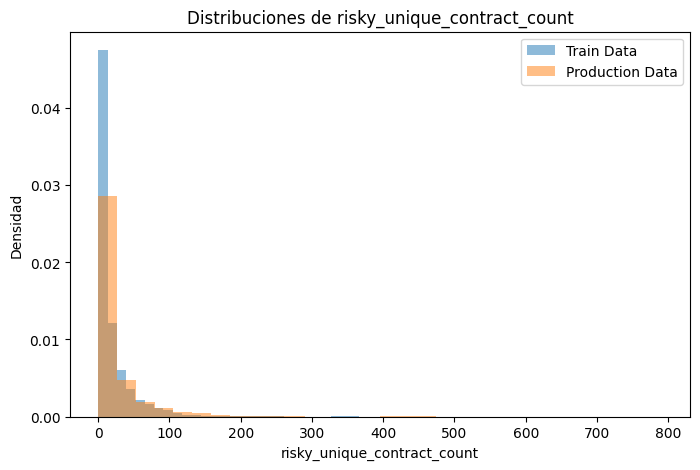

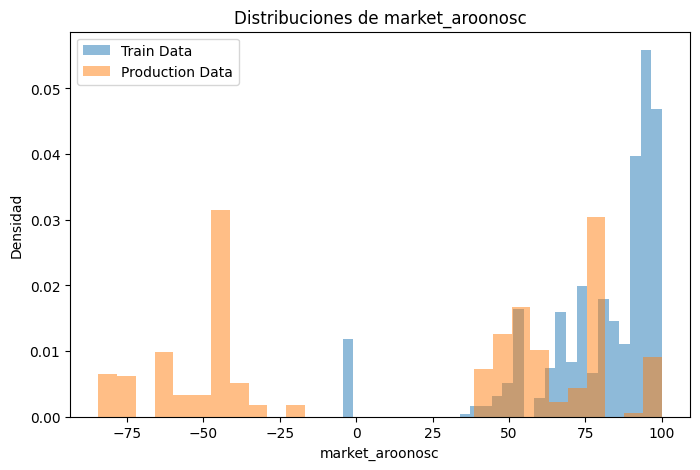

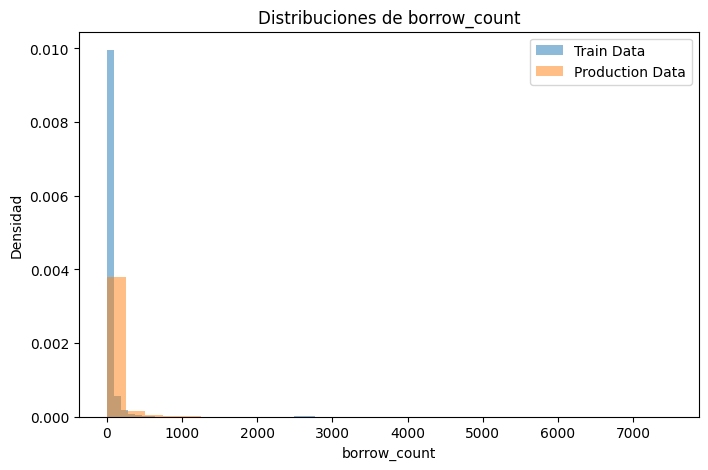

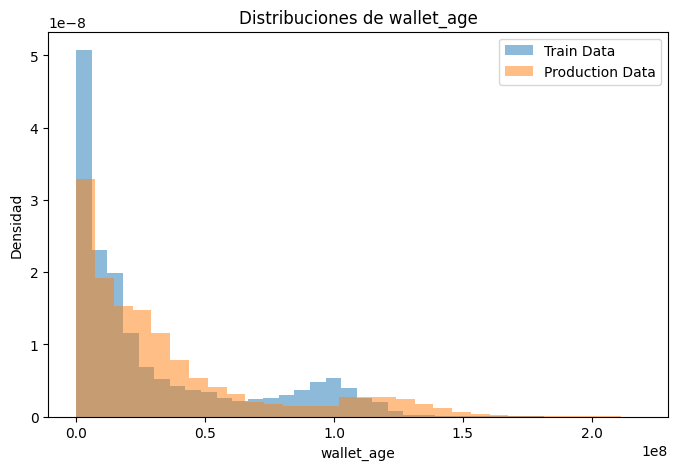

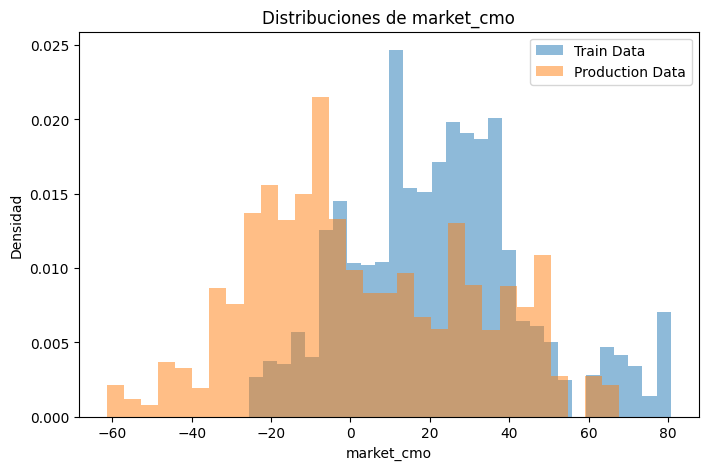

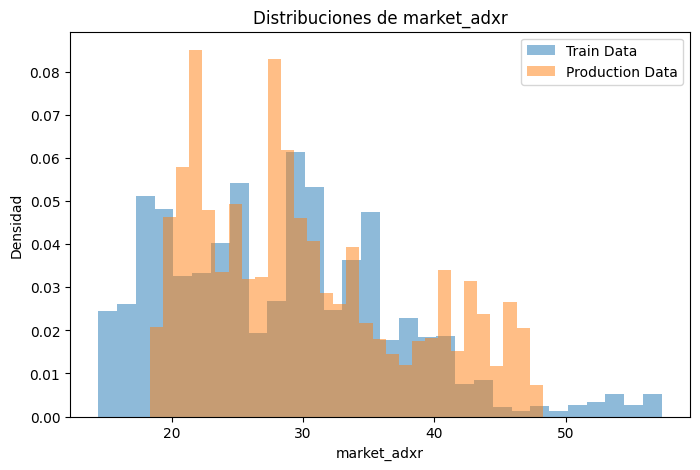

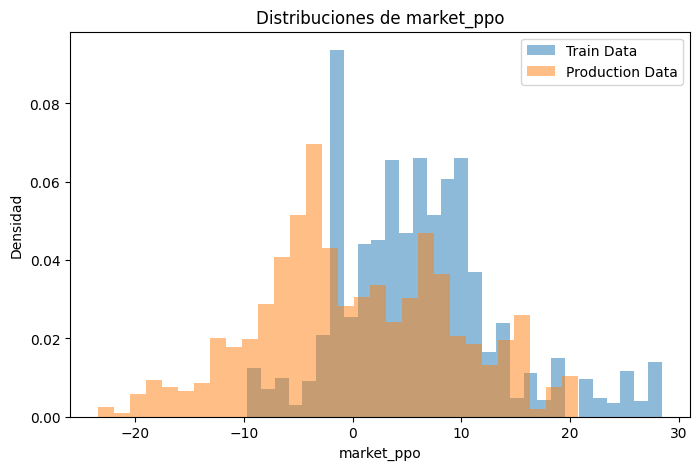

In [111]:
#veamos ahora en el caso de X_t2
plot_feature_distributions(data_train=X_t1_new, data_production=X_t2, features=features_to_check)

Nuevamente, se tiene la presencia de data drift.
Para afrontar este problema, conviene re entrenar el modelo con la nueva distribución de los datos de la manera que se hizo en la segunda etapa del proyecto. En cuánto al desbalance de clases, se tiene dos casos posibles, el primero es el desbalance en la variable target, lo cual sería detectado por la función de target drift ya que los datos incialmente presentan un balance en esta clase, por otro lado, un desbalance en las demás variables puede ser detectado también por el data drift en caso de que las clases estuvieran balanceadas; si las clases estuvieran desbalanceadas y se mantienen en el desbalance, esto no sería detectado por el data drift pero tampoco es tan perjudicial considerando que el modelo escogido es XGBoost, que es capaz de sobrellevar estas situaciones dada su arquitectura de boosting, y en caso de que este desbalance sea nuevo, será detectado por el data drift y basta con re entrenar para que el modelo se adapte a la nueva distribución de datos.  

In [113]:
X_t2_iter_3 = pd.read_parquet(DATA_PATH + "X_t2.parquet").reset_index(drop=True)
y_t2_iter_3 = pd.read_parquet(DATA_PATH + "y_t2.parquet").reset_index(drop=True)

X_t3_iter_3 = pd.read_parquet(DATA_PATH + "X_t3.parquet").reset_index(drop=True)

In [114]:
detect_drift(train_data = X_t2_iter_3,production_data = X_t3_iter_3, features = features_to_check, method= 'cv')

True

Al verificar con los nuevos datos, y con el último modelo reentrenado, se detecta data drift, lo que indica una desviación de los datos respecto a los que se tenian al momento del entrenamiento. Considerando esto, es importante reentrenar el modelo para que aprenda la nueva distribución de los datos y pueda seguir realizando predicciones de manera correcta.

In [115]:
retrain_model(
    pipeline_or_path="xgboost_model_post_retrain.pkl",
    X=X_t2_iter_3,
    y=y_t2_iter_3,
    fun_to_update_model=function_to_retrain_XGB,
    save_model_path="xgboost_model_post_retrain_iter_3.pkl",
    test_size=0.2,
    random_state=42,
    optimize=True,
    get_optuna_params=lambda trial: {
        "max_depth": trial.suggest_int("max_depth", 1, 32),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 32),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
    },
    n_trials=5,
)

Traceback (most recent call last):
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucas\python-envs\nb-env\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^

Evaluación en el conjunto de prueba:
Métricas del modelo:
    accuracy: 0.8165758952507266
    precision: 0.8379797594042391
    recall: 0.6463181148748159
    f1_score: 0.729774673650952
    roc_auc: 0.8796748149354523
Confusion matrix:
[[20160  1697]
 [ 4803  8777]]
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     21857
           1       0.84      0.65      0.73     13580

    accuracy                           0.82     35437
   macro avg       0.82      0.78      0.80     35437
weighted avg       0.82      0.82      0.81     35437



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('dropper',
                                                                   FunctionTransformer(func=<function drop_columns at 0x0000026973549580>,
                                                                                       kw_args={'features_to_drop': ['borrow_block_number',
                                                                                                                     'wallet_address',
                                                                                                                     'borrow_timestamp',
                                                                                                                     'first_tx_timestamp',
                                                                                                                     'last_tx_timestamp',
                                                                                                                     'risky_first_tx_timestamp',
                                                                                                                     'risky_last_tx_timestamp',
                                                                                                                     'un...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.009112498314815858, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=25,
                               max_leaves=None, min_child_weight=10,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])